<a href="https://colab.research.google.com/github/MarkovMarkowitz/MarkovMarkowitz/blob/main/ON_Trading_Strategy_Functions_v5_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [150]:
!pip3 install pyfolio
!pip install datetime


# Notebook Instructions

1. If you are new to Jupyter notebooks, please go through this introductory manual <a href='https://quantra.quantinsti.com/quantra-notebook' target="_blank">here</a>.
1. Any changes made in this notebook would be lost after you close the browser window. **You can download the notebook to save your work on your PC.**
1. Before running this notebook on your local PC:<br>
i.  You need to set up a Python environment and the relevant packages on your local PC. To do so, go through the section on "**Run Codes Locally on Your Machine**" in the course.<br>
ii. You need to **download the zip file available in the last unit** of this course. The zip file contains the data files and/or python modules that might be required to run this notebook.

In [151]:

import datetime
import pyfolio as pyf
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt

current_date = datetime.datetime.now()

delta = 1
day = current_date.day
month = current_date.month
year = current_date.year - delta

START = f'{year}-{month}-{day}'
END = f'{year+delta}-{month}-{day}'

VOLATILITY_FACTOR = 0.45
R_WINDOW = 32
REVERSED = True
LEFT, RIGHT = datetime.date(year, month, day), datetime.date(year+delta, month, day)

Ticker = "EREGL"    # EREGL, ASELS, KCHOL THYAO akşam al sabah sata uygun
TickerIS = Ticker + ".IS"

TR_Tickers = ["EREGL", "CANTE", "GARAN", "KCHOL", "EUPWR"]
US_Tickers = ["TSLA", "AAPL", "GOOGL", "BA", "V"]
DOW30 = ["AXP","AMGN","AAPL","BA","CAT","CSCO","CVX","GS","HD","HON","IBM","JNJ","KO","JPM",
         "MCD","MMM","MRK","MSFT","NKE","PG","TRV","UNH","CRM","VZ","V","WBA","WMT","DIS","DOW"]

BIST30 = ["AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","KRDMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK"]

BIST100 = ["AKBNK","ALARK","ARCLK","ASELS","BIMAS","EKGYO","ENKAI","EREGL","FROTO","GARAN",
          "GUBRF","HEKTS","ISCTR","KOZAA","KOZAL","K DMD","ODAS","PETKM","PGSUS","SAHOL","SASA",
          "SISE","TAVHL","TCELL","THYAO","TOASO","TUPRS","YKBNK",
          "AEFES","AGHOL","AHGAZ","AKCNS","AKFGY","AKSA","AKSEN",
           "ALBRK","ASUZU","AYDEM","BAGFS","BERA",
           "BRSAN","BRYAT","BUCIM","CANTE","CCOLA","CEMTS","CIMSA",
           "DOAS","DOHOL","ECILC","ECZYT","EGEEN","ENJSA",
           "GENIL","GESAN","GLYHO","GSDHO","GWIND","HALKB","IPEKE",
           "ISDMR","ISGYO","ISMEN","IZMDC","KARSN","KMPUR",
           "KONTR","KONYA","KORDS","KZBGY","MAVI","OTKAR","OYAKC",
           "PENTA","PETKM","QUAGR","SELEC","SKBNK","SMRTG",
           "SNGYO","SOKM","TAVHL","TKFEN","TKNSA","TOASO","TSKB",
           "TTKOM","TTRAK","TUKAS","ULKER","VAKBN","VESBE","ZOREN"]


In [152]:
def ConvertToUSD(ticker, start, end):
    close = yf.download(ticker,start,end)['Adj Close']
    open = yf.download(ticker,start,end)['Open']
    usdtry = yf.download('TRY=X',start,end)['Adj Close']
    for i in np.arange(0,len(close)):
        close[i] = close[i]/usdtry[i]
        open[i] = open[i]/usdtry[i]
    rets = close.pct_change()
    return close, open, rets

In [153]:
def UpdateData(TickerIS, START, END):

  # For data manupulations

  # VF    LB    PEAK_CUM  CUM_LAST    REVERSED
  # 0.25  45    6.11       4.29 OK    True
  # 0.35  45    7.42       5.02 OK    True
  # 0.40  45    7.64       5.17 OK    True
  # 0.45  45    8.99       6.16 OK    True
  # 0.45  45    1.22       1.05 OK    False
  # 0.45  55    7.97       5.39 OK    True
  # 0.45  40    9.35       6.31 OK    True
  # 0.45  35    9.65       7.14 OK    True
  # 0.45  33    9.78       7.24 OK    True  ***
  # 0.45  32    10.02      7.42 OK    True  ****
  # 0.45  30    9.16       6.78 OK    True
  # 0.45  25    8.19       5.98 OK    True
  # -   -       5.17       4.82 OK    True / original Gap up buy side.

  # Read data from Yahoo finance

  data = yf.download(TickerIS,START, END)
  # Convert index into datetime format
  data.index = pd.to_datetime(data.index,format="%d-%m-%Y")
  # Calculate adjustment factor
  adjusted_factor = data['Adj Close'] / data['Close']

  # Calculate adjusted open price
  data['close=usd'], data['open=usd'], data['rets=usd'] = ConvertToUSD(TickerIS, START, END)

  data['Adj Open'] = adjusted_factor * data['Open']

  data['returns'] = (data['Adj Open'] - data['Adj Close'].shift(1)) / data['Adj Close'].shift(1)

  data['open=usd=adj'] = adjusted_factor * data['open=usd']
  data['rets=usd'] = (data['open=usd=adj'] - data['close=usd'].shift(1)) / data['close=usd'].shift(1)

  data['std'] = data['returns'].rolling(R_WINDOW).std()

  data['positions'] = np.nan
  data['close']= data['Adj Close']


  data['std=usd'] = data['rets=usd'].rolling(R_WINDOW).std()

  data["log_returns"] = data['close'].pct_change().apply(lambda x: np.log(1+x))
  data["log_returns=usd"] = data['close=usd'].pct_change().apply(lambda x: np.log(1+x))

  data["rel"]= data['Adj Close'] / data['Adj Close'][0]
  data["rel=usd"]= data['close=usd'] / data['close=usd'][0]

  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true

  # Long entry condition
  if REVERSED:
    long_entry_usd = data['rets=usd'] < VOLATILITY_FACTOR  * data['std=usd']
    short_entry_usd = data['rets=usd'] >= VOLATILITY_FACTOR  * data['std=usd']
  else:
  # Short entry condition
    long_entry_usd = data['rets=usd'] < VOLATILITY_FACTOR  * data['std=usd']
    short_entry_usd = data['rets=usd'] >= VOLATILITY_FACTOR  * data['std=usd']
  # Store 1 when long entry condition is true

  data.loc[long_entry_usd, 'positions_usd'] = 1
  data.loc[short_entry_usd, 'positions_usd'] = 0

  data.loc[long_entry_usd, 'positions_usd'] = 1
  data.loc[short_entry_usd, 'positions_usd'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  data['positions_usd'].fillna(method='ffill', inplace=True)

  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  data['strategy_returns=usd'] = ((data['close=usd'] - data['open=usd=adj']) / data['open=usd=adj']) * data.positions_usd

  data['cumulative_normal_returns'] = (data.returns+1).cumprod()
  data['cumulative_normal_returns=usd'] = (data['rets=usd']+1).cumprod()

  data['cumulative_strategy_returns'] = (data.strategy_returns+1).cumprod()
  data['cumulative_strategy_returns=usd'] = (data['strategy_returns=usd']+1).cumprod()

  return data

In [154]:
# #GAP UP-GAP DOWN STRATEGY

# # Long entry condition
# long_entry = data['Adj Open'] > data['Adj Close'].shift(1)

# # Short entry condition
# short_entry = data['Adj Open'] < data['Adj Close'].shift(1)

In [155]:
# IMPROVED STRATEGY
def Strategy(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true
  data.loc[long_entry, 'positions'] = 1

  # Store -1 when short entry condition is true
  # data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  return data



In [156]:
# IMPROVED STRATEGY
def Volatility_Strategy_USD_TR(data):
  global VOLATILITY_FACTOR
  # Long entry condition
  if REVERSED:
    long_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
  else:
  # Short entry condition
    long_entry = data['returns'] >= VOLATILITY_FACTOR  * data['std']
    short_entry = data['returns'] < VOLATILITY_FACTOR  * data['std']
  # Store 1 when long entry condition is true

  if REVERSED:
    long_entry_usd = data['rets=usd'] < VOLATILITY_FACTOR  * data['std=usd']
    short_entry_usd = data['rets=usd'] >= VOLATILITY_FACTOR  * data['std=usd']
  else:
  # Short entry condition
    long_entry = data['rets=usd'] >= VOLATILITY_FACTOR  * data['std=usd']
    short_entry = data['rets=usd'] < VOLATILITY_FACTOR  * data['std=usd']
  # Store 1 when long entry condition is true

  data.loc[long_entry, 'positions'] = 1
  data.loc[long_entry_usd, 'positions_usd'] = 1

  # Store -1 when short entry condition is true
  data.loc[short_entry, 'positions'] = -1

  # Store 0 when wait condition is true
  data.loc[short_entry, 'positions'] = 0
  data.loc[short_entry_usd, 'positions_usd'] = 0

  data['positions'].fillna(method='ffill', inplace=True)
  data['positions_usd'].fillna(method='ffill', inplace=True)

  return data



In [157]:


# Drop NaN values
#data = data.dropna()

In [158]:
def CalculateStrReturns(data):
  data['strategy_returns'] = ((data['Adj Close'] - data['Adj Open']) / data['Adj Open']) * data.positions
  return data

In [159]:
def PlotRelative(data):
  global  LEFT, RIGHT, R_WINDOW
  plt.subplot(4, 1, 1)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['close'])
  plt.title(f"{Ticker} time series")

  plt.subplot(4, 1, 2)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['rel'])
  plt.title(f"{Ticker} relative time series")



  plt.subplot(4, 1, 3)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['log_returns'])
  plt.title(f"{Ticker} returns time series")

  plt.subplot(4, 1, 4)
  plt.xlim(LEFT, RIGHT)
  data_vlt = data['close'].rolling(R_WINDOW).std()*(252**0.5)

  plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  plt.plot(data['std']*252**0.5)

  fig = plt.gcf()
  fig.set_size_inches(16, 16)
  plt.show()

In [160]:
def PlotFunction(Ticker,data):
  # Plot cumulative returns

  import datetime

  plt.figure(figsize=(14,11))

  plt.subplot(4, 1, 1)
  global LEFT, RIGHT
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['close'])
  plt.title(f"{Ticker} price time series", fontsize=16)
  #plt.xlabel('Date', fontsize=14)
  plt.ylabel('Price', fontsize=14)
  plt.grid(True)

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 2)
  plt.xlim(LEFT, RIGHT)


  plt.plot(data.cumulative_normal_returns)
  plt.title(f"{Ticker} normal returns")
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Cumulative strategy returns
  # Define the label for the title of the figure
  plt.title(f"{Ticker} Cumulative Returns", fontsize=16)
  # Define the labels for x-axis and y-axis
  #plt.xlabel('Date', fontsize=14)
  plt.ylabel('Day Trade Strategy Returns', fontsize=14)

  # Define the tick size for x-axis and y-axis
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 3)
  plt.xlim(LEFT, RIGHT)



  plt.plot(data.cumulative_strategy_returns)
  plt.title(f"{Ticker} returns time series")
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # Cumulative strategy returns
  # Define the label for the title of the figure
  plt.title(f"{Ticker} Cumulative Strategy Returns", fontsize=16)
  # Define the labels for x-axis and y-axis
  #plt.xlabel('Date', fontsize=14)
  plt.ylabel('Cumulative Returns', fontsize=14)

  # Define the tick size for x-axis and y-axis
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 4)
  plt.xlim(LEFT, RIGHT)
  plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  #plt.xlabel('Date', fontsize=14)
  plt.ylabel(f'{Ticker} volatility', fontsize=14)
  plt.grid(True)
  plt.xticks(fontsize=12)

  plt.plot(data['std']*252**0.5)
  fig = plt.gcf()
  fig.set_size_inches(16, 22)
  plt.show()

In [161]:
def PlotUSDTROpenClosePerformance(Ticker,data):
  print(f"Plotting Open-Close Performance for {Ticker}")
  # Plot cumulative returns
  global LEFT, RIGHT
  import datetime

  fig = plt.gcf()
  fig.set_size_inches(16, 22)

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 1)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['close=usd'])
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} USD price", fontsize=12)
  #plt.xlabel('Date', fontsize=12)
  plt.ylabel('Price USD', fontsize=12)

  # ----------------------------------------------------------------------------------
  plt.subplot(4, 1, 2)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['cumulative_normal_returns=usd'])
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} USD Normal Returns", fontsize=12)
  #plt.xlabel('Date', fontsize=12)
  plt.ylabel('Open-Close Trade Strategy Returns', fontsize=12)

 #----------------------------------------------------------------------------------
  plt.subplot(4, 1, 3)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['close'])
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} TL price", fontsize=12)
  #plt.xlabel('Date', fontsize=12)
  plt.ylabel('Price TL', fontsize=12)

  #----------------------------------------------------------------------------------
  plt.subplot(4, 1, 4)
  plt.xlim(LEFT, RIGHT)
  plt.plot(data['cumulative_normal_returns'])
  plt.grid(True)
  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.title(f"{Ticker} TL Open-Close Strategy", fontsize=12)
  #plt.xlabel('Date', fontsize=12)
  plt.ylabel('Open-Close Strategy TL Returns', fontsize=12)

  # ----------------------------------------------------------------------------------
  # plt.subplot(4, 1, 4)
  # plt.xlim(LEFT, RIGHT)
  # plt.title(f"{Ticker} {R_WINDOW}-day rolling volatility")
  # plt.xlabel('Date', fontsize=14)
  # plt.ylabel(f'{Ticker} volatility', fontsize=14)
  # plt.grid()
  # plt.xticks(fontsize=12)

  # plt.plot(data['std=usd']*252**0.5)

  plt.show()

In [162]:
def ShowDataTable(data):
  global year, day, month
  return(data.loc[f'{year}-{month}-{day}':f'{year+delta}-{month}-{day}'].dropna())




In [163]:
def CreateTearSheetForData(data):
  pyf.create_simple_tear_sheet(data.returns.dropna())

def CreateTearSheetForData_v2(data):
  pyf.create_simple_tear_sheet(data['rets=usd'].dropna())


In [164]:
def EvaluateFeasibility(data):
  Max_Cum_Norm_Ret = np.max(data.cumulative_normal_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns[-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return feasible

In [165]:
def EvaluateFeasibility_TR(data):
  Max_Cum_Norm_Ret = np.max(data.cumulative_normal_returns)
  Max_Cum_Str_Ret = np.max(data.cumulative_strategy_returns)

  Last_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  Last_Cum_Str_Ret = data.cumulative_strategy_returns[-1]

  Latest_Rel = data['rel'][-1]
  Latest_Cum_Norm_Ret = data.cumulative_normal_returns[-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return Latest_Cum_Norm_Ret, Latest_Rel,feasible

In [166]:
def EvaluateFeasibility_USD(data):
  Max_Cum_Norm_Ret = np.max(data['cumulative_normal_returns=usd'])
  Max_Cum_Str_Ret = np.max(data['cumulative_strategy_returns=usd'])

  Last_Cum_Norm_Ret = data['cumulative_normal_returns=usd'][-1]
  Last_Cum_Str_Ret = data['cumulative_strategy_returns=usd'][-1]

  Latest_Rel = data['rel=usd'][-1]
  Latest_Cum_Norm_Ret = data['cumulative_normal_returns=usd'][-1]
  feasible = Latest_Cum_Norm_Ret / Latest_Rel
  return Latest_Cum_Norm_Ret, Latest_Rel,feasible


In [167]:
def ShowTRMarket(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:
    ticker = ticker + ".IS"
    d = UpdateData(ticker, START, END)
    d = Strategy(d)
    opc,clo,fb = EvaluateFeasibility_TR(d)
    if fb>1.0 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df



In [168]:
def ShowTRMarket_v2(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:
    ticker = ticker + ".IS"
    d = UpdateData(ticker, START, END)
    d = Volatility_Strategy_USD_TR(d)
    opc,clo,fb = EvaluateFeasibility_USD(d)
    if fb>1.2 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df



In [169]:
def ShowUSMarket(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:

    d = UpdateData(ticker, START, END)
    d = Strategy(d)
    opc,clo,fb = EvaluateFeasibility_TR(d)
    if fb>1.0 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df


In [170]:
def ShowUSMarket_v2(Tickers):

  my_dict = {'Ticker':[], 'Open-Close':[],'Close':[],'Eff':[]};

  for ticker in Tickers:

    d = UpdateData(ticker, START, END)
    d = Volatility_Strategy_USD_TR(d)
    opc,clo,fb = EvaluateFeasibility_TR(d)
    if fb>1.2 :

      my_dict['Ticker'].append(ticker)
      my_dict['Eff'].append(fb)
      my_dict['Open-Close'].append(opc)
      my_dict['Close'].append(clo)

  df = pd.DataFrame(my_dict)
  df.sort_values(by=['Open-Close'], ascending=False, inplace=True)
  print(df)
  return df


In [171]:
def ShowTickerStats(ticker, exchange):

  print(f"Updating data for {ticker}")
  d = UpdateData(ticker, START, END)

  print(f"Applying Strategy data for {ticker}")
  d = Volatility_Strategy_USD_TR(d)

  PlotUSDTROpenClosePerformance(ticker, d)
  print(f"Creating Tear Sheet for {ticker}")
  CreateTearSheetForData_v2(d)
  return d

In [172]:
def EmpyrialPortfolioPerformance():
  !pip install Scikit-learn
  !pip install empyrial

  from empyrial import empyrial, Engine

  pf2 = Engine(
                    start_date= START, #start date for the backtesting
                    portfolio = ["ODAS.IS", "ALARK.IS", "KOZAA.IS", "ENKAI.IS","KRDMD.IS", "ISCTR.IS", "PETKM.IS", "TAVHL.IS", "EREGL.IS"],
                    optimizer = "MEANVAR", # defines Mean-Variance as the optimizer
                    max_vol = 40, #maximize the return for this level of volatility (25%)
                    benchmark = ["TRY=X"], #NIFTY50 is set by default
                    #rebalance = "1Y" #rebalance every year
                    #risk_manager = {"Take Profit" : 1} #Stop the investment when the profit becomes superior to 25%
  )
  empyrial(pf2)
  empyrial.orderbook


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

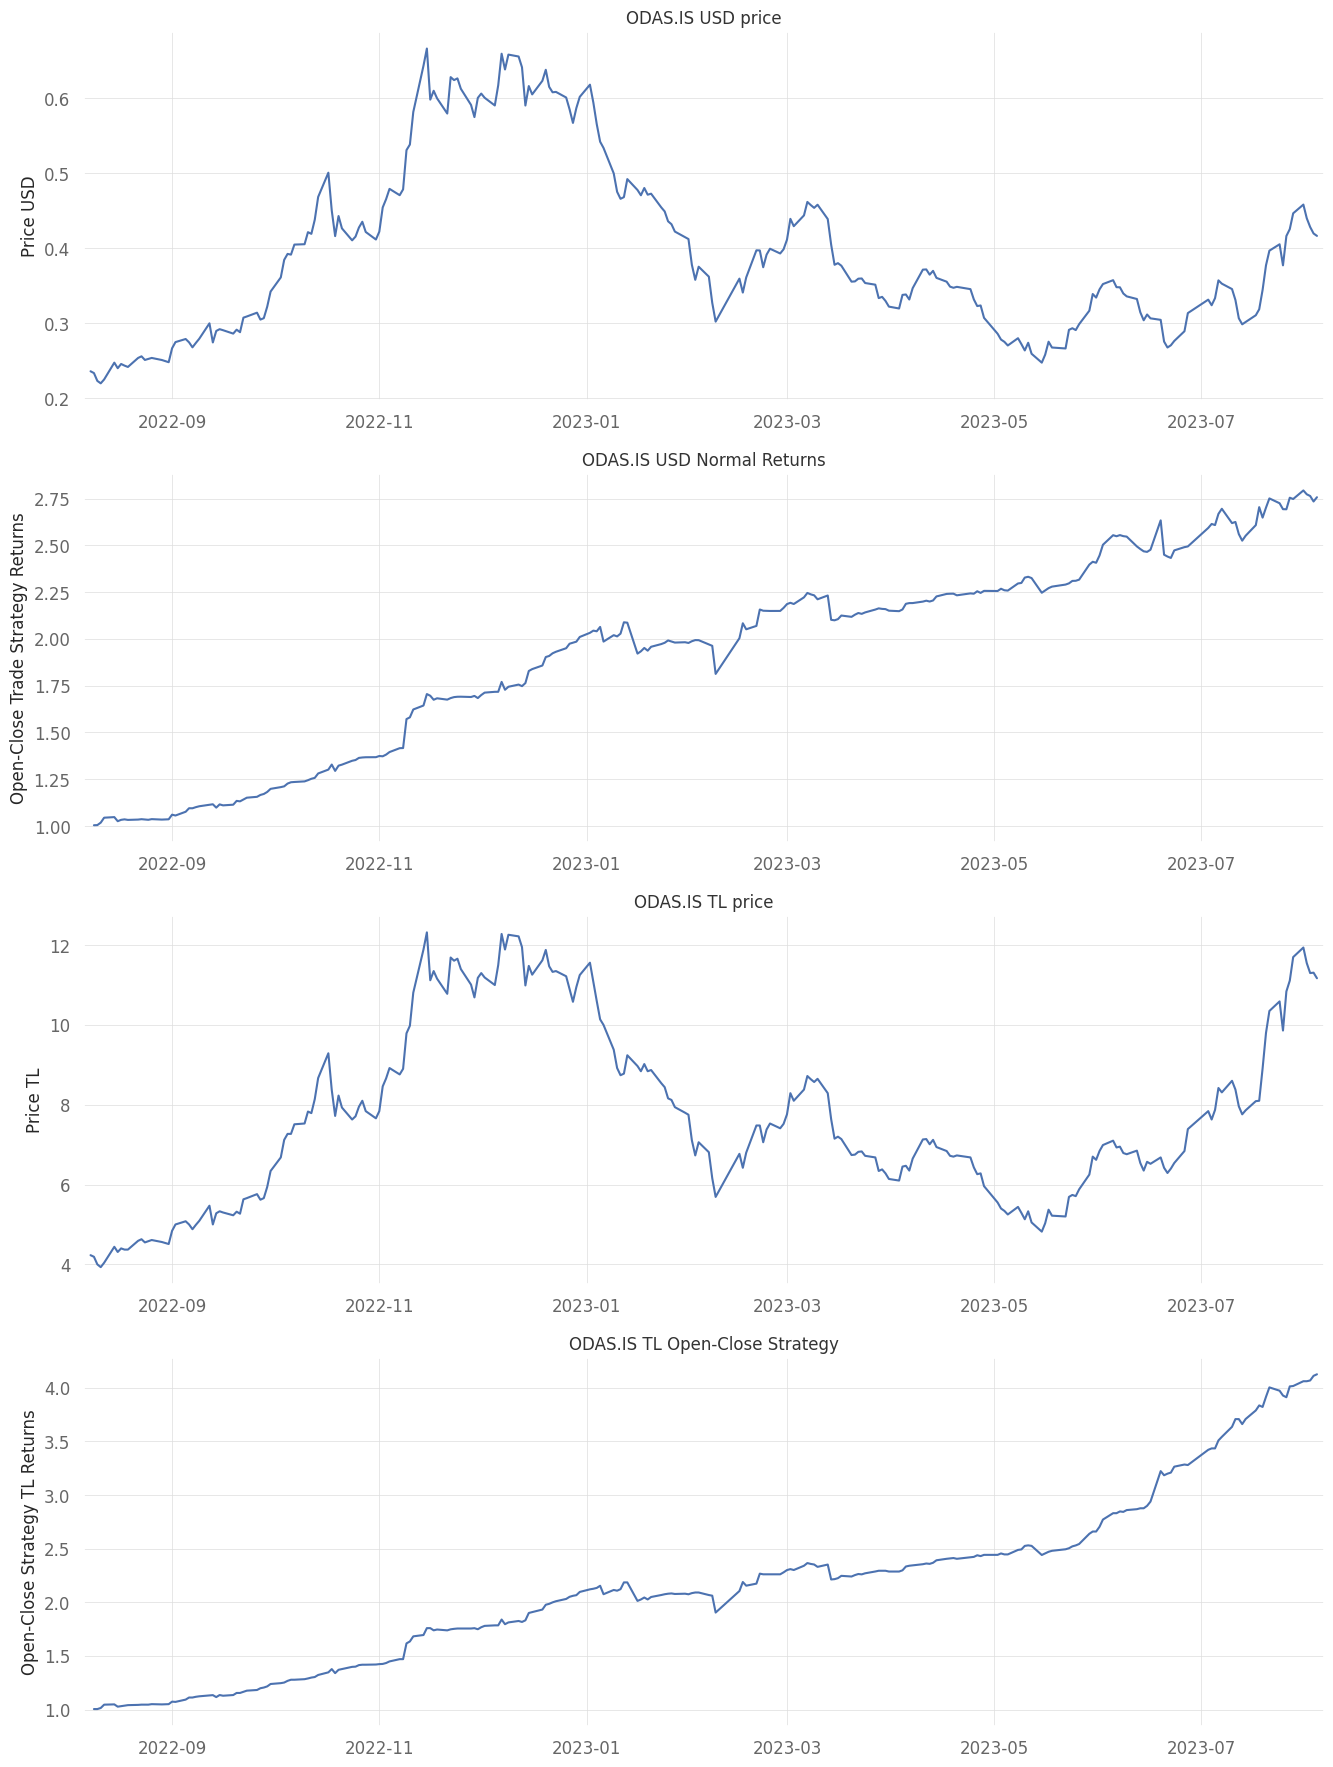

Creating Tear Sheet for ODAS.IS


Updating data for ALARK.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for ALARK.IS
Plotting Open-Close Performance for ALARK.IS


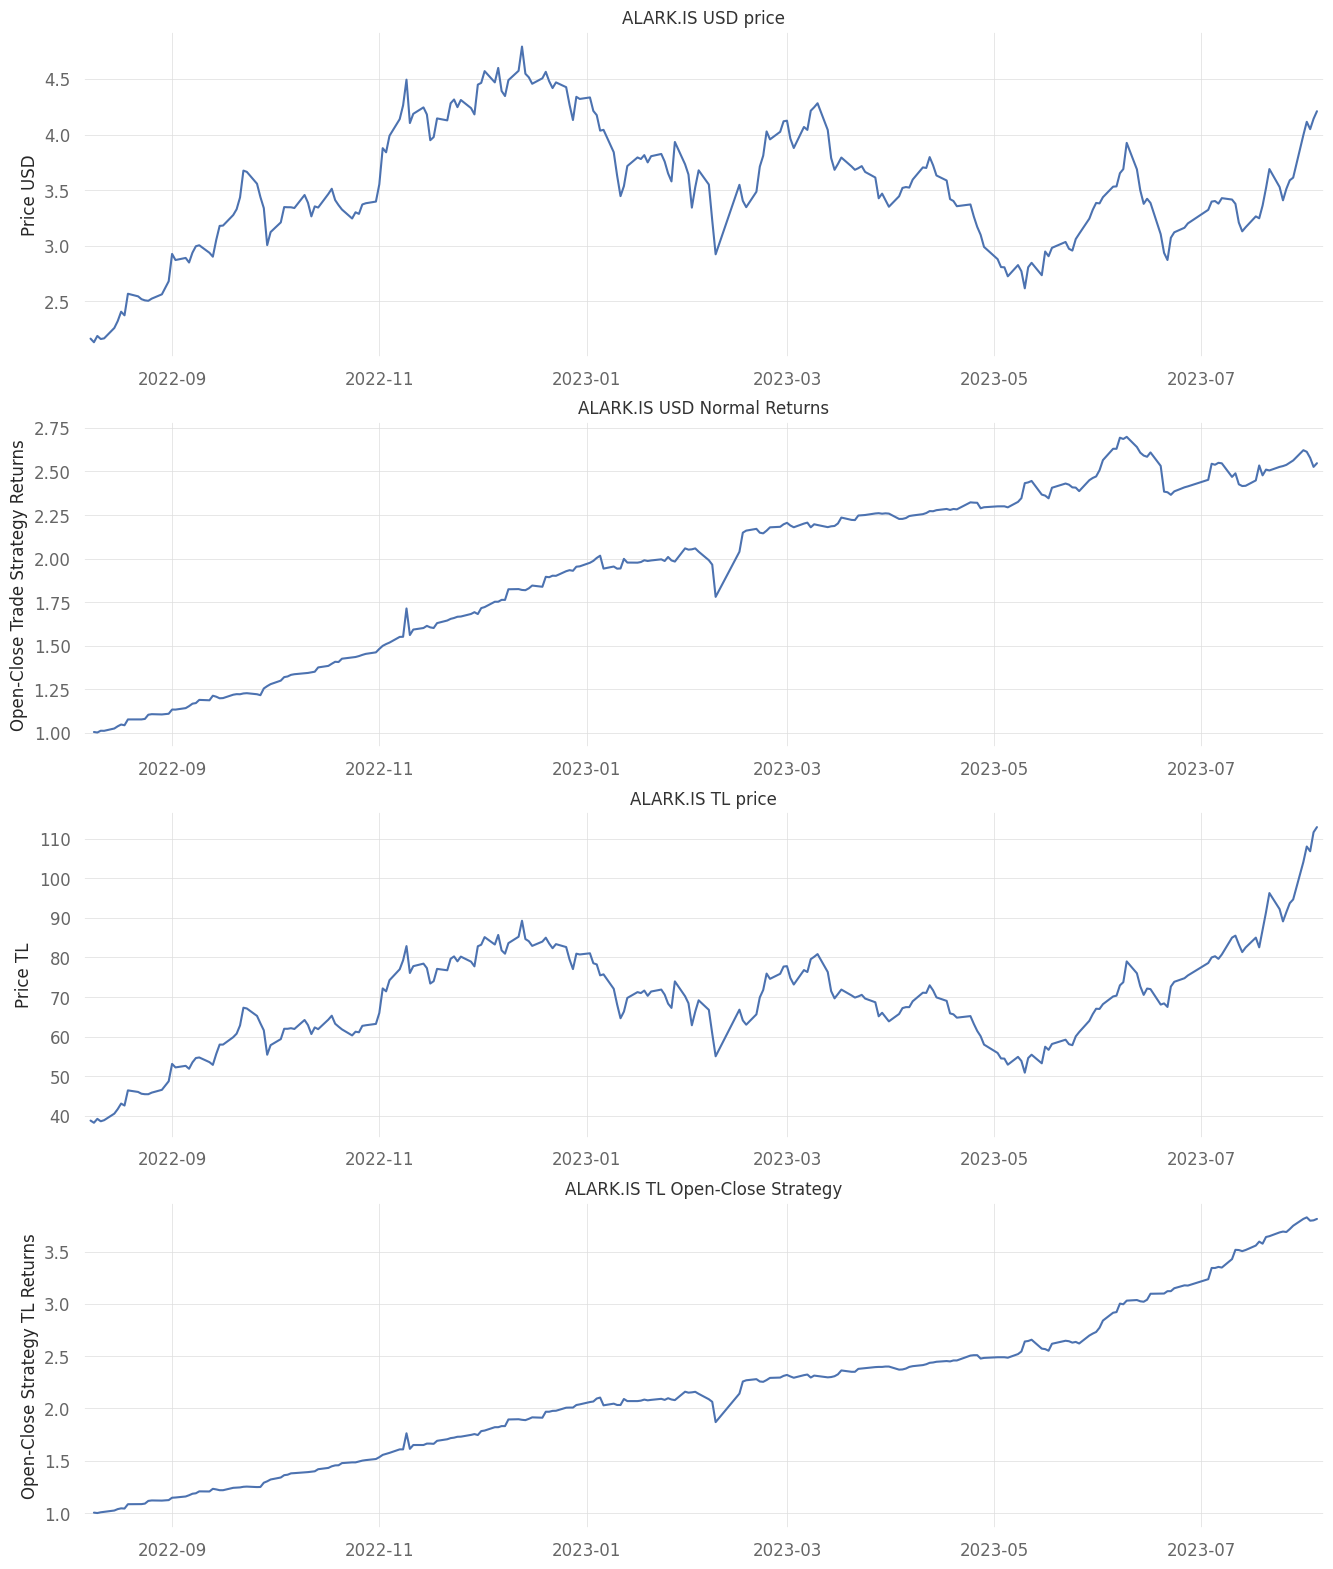

Creating Tear Sheet for ALARK.IS


Updating data for KOZAA.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for KOZAA.IS
Plotting Open-Close Performance for KOZAA.IS


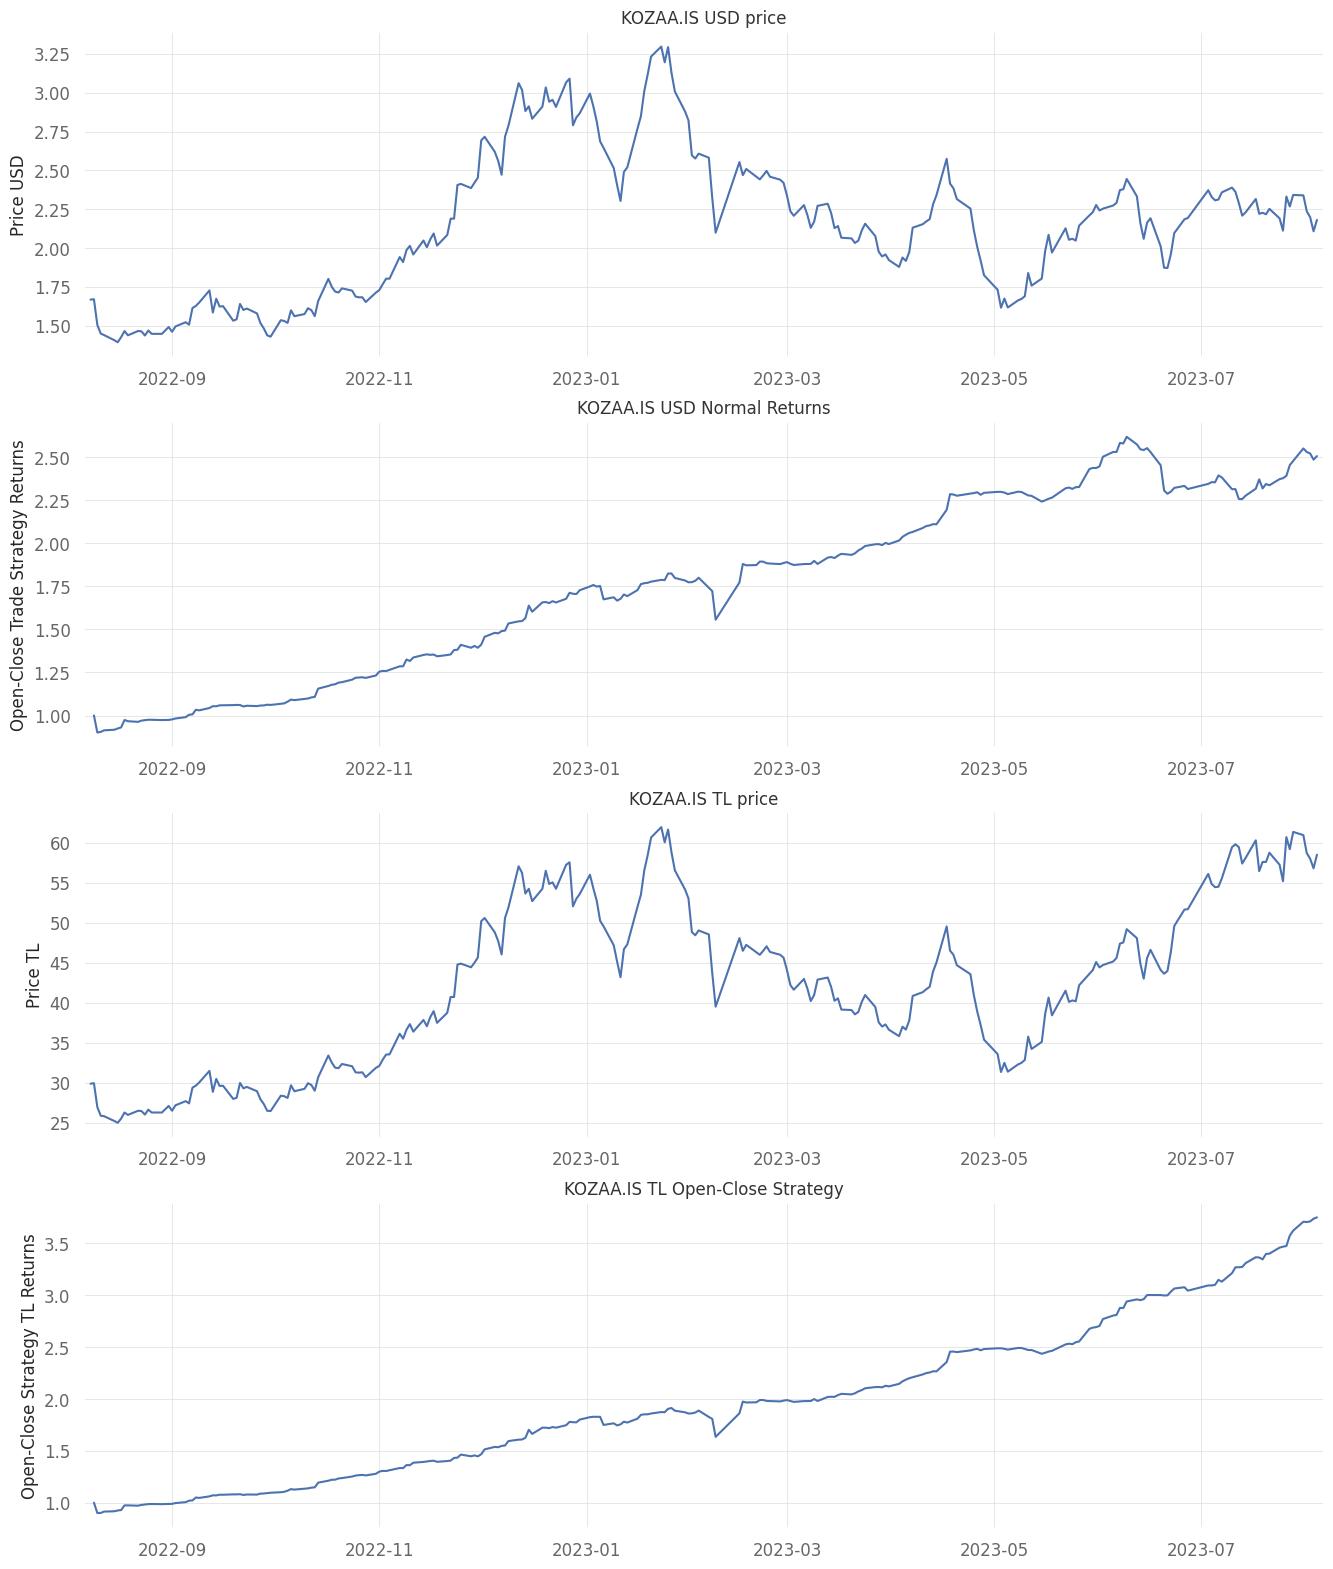

Creating Tear Sheet for KOZAA.IS


Updating data for KRDMD.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for KRDMD.IS
Plotting Open-Close Performance for KRDMD.IS


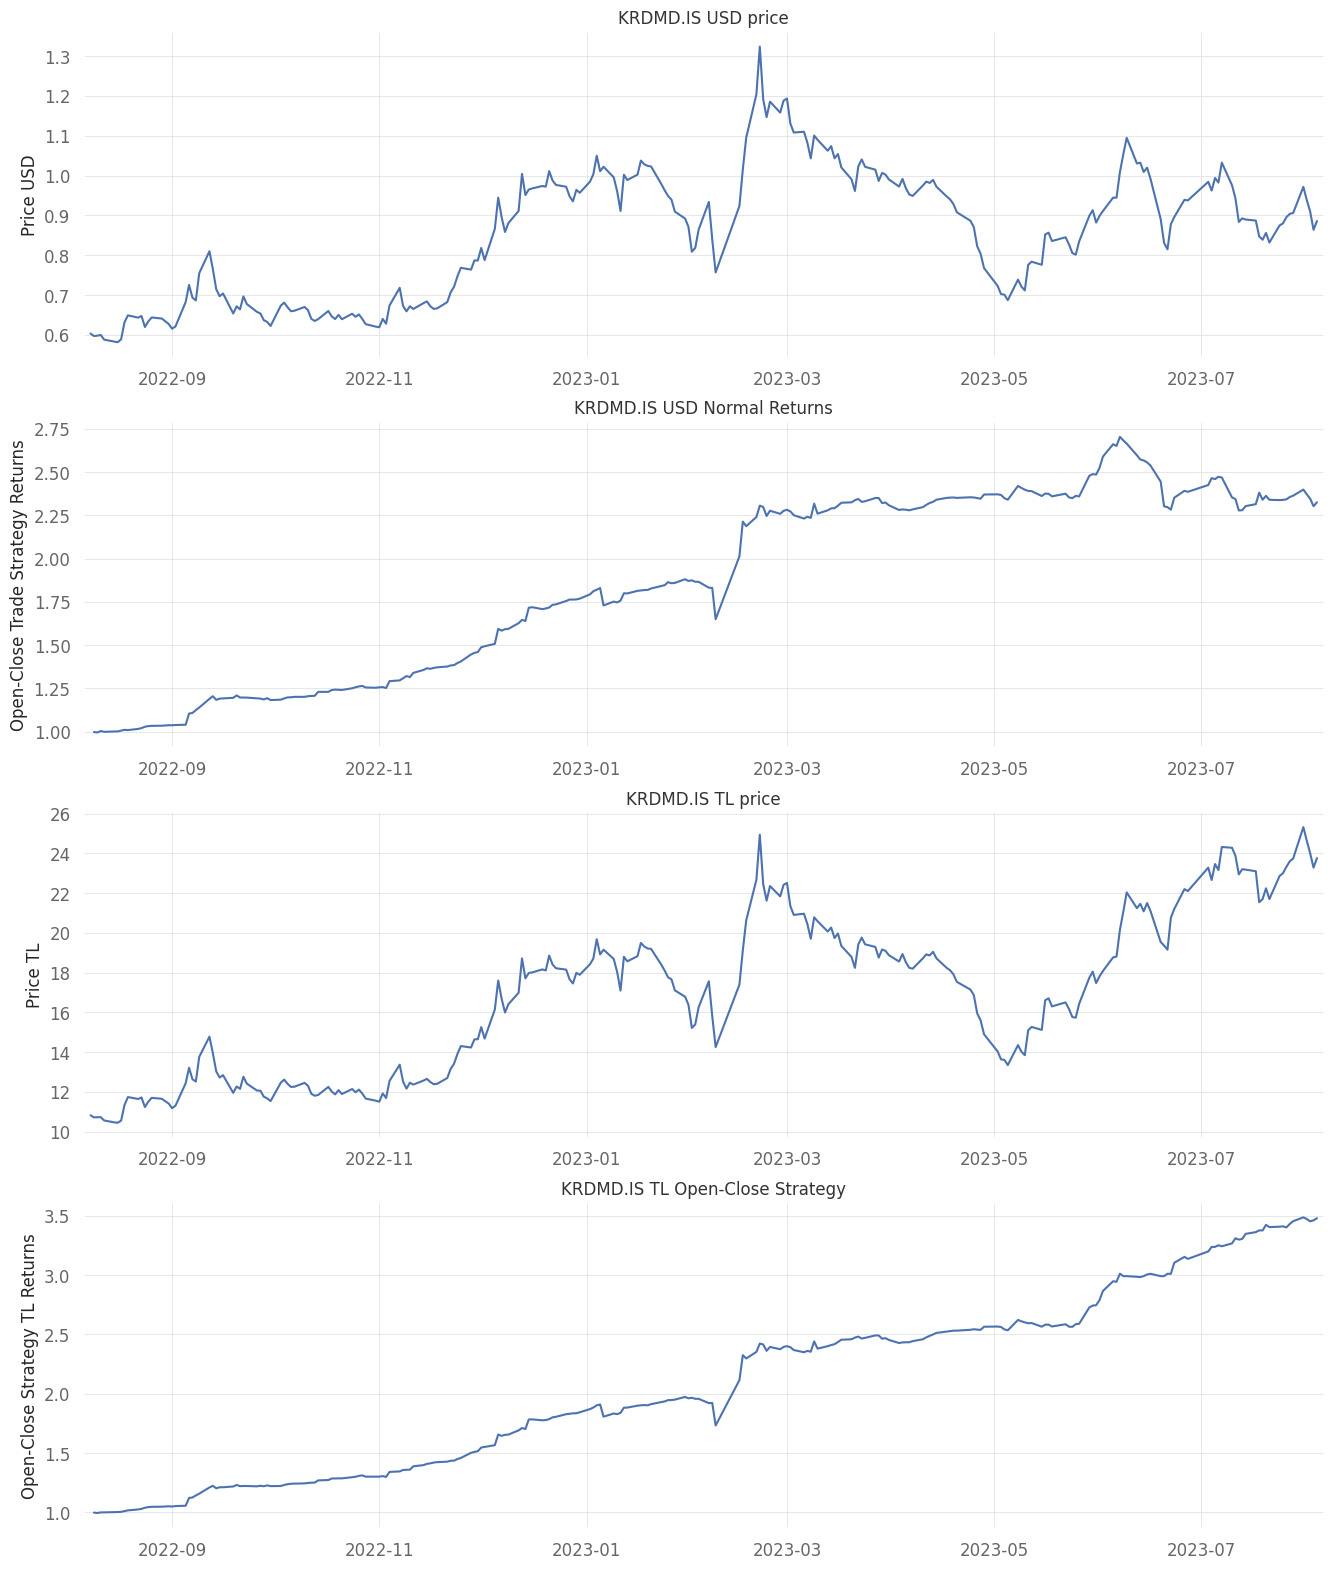

Creating Tear Sheet for KRDMD.IS


Updating data for ENKAI.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for ENKAI.IS
Plotting Open-Close Performance for ENKAI.IS


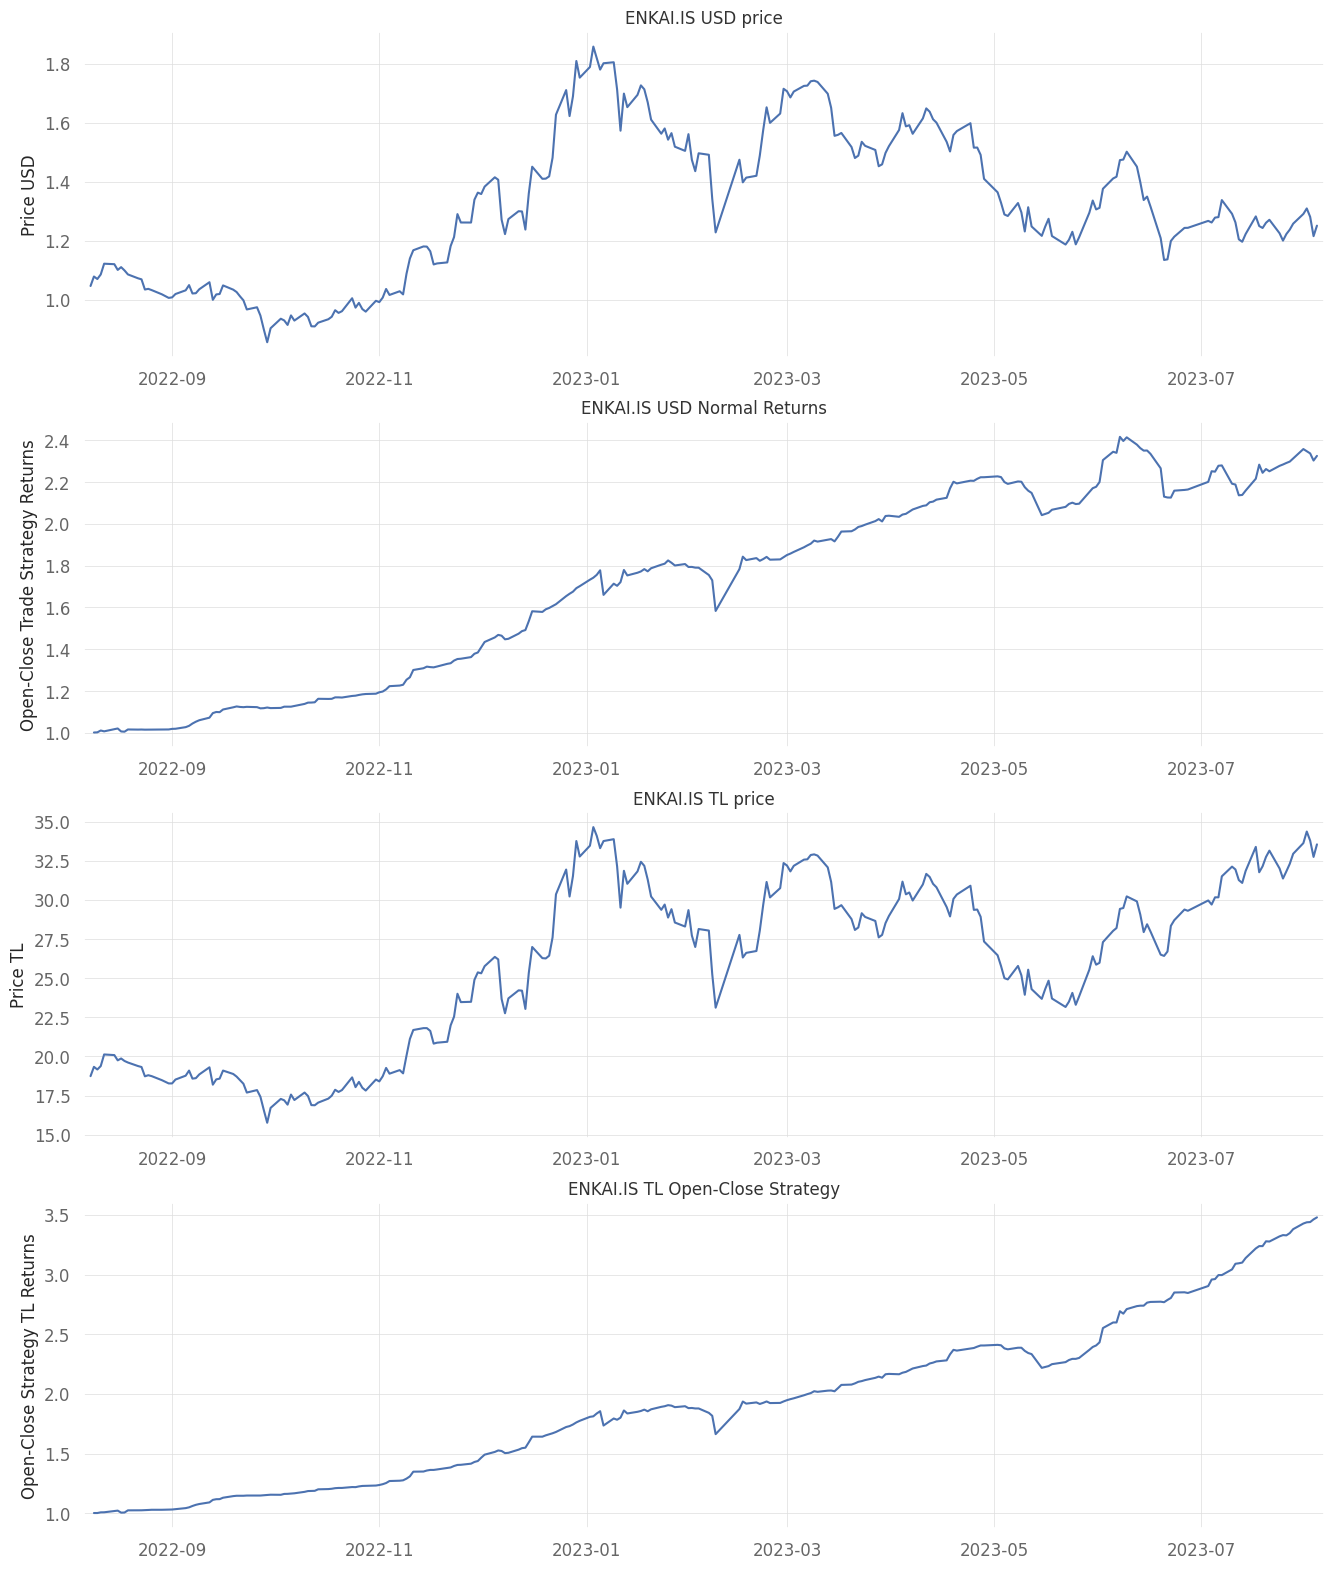

Creating Tear Sheet for ENKAI.IS


Updating data for ISCTR.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for ISCTR.IS
Plotting Open-Close Performance for ISCTR.IS


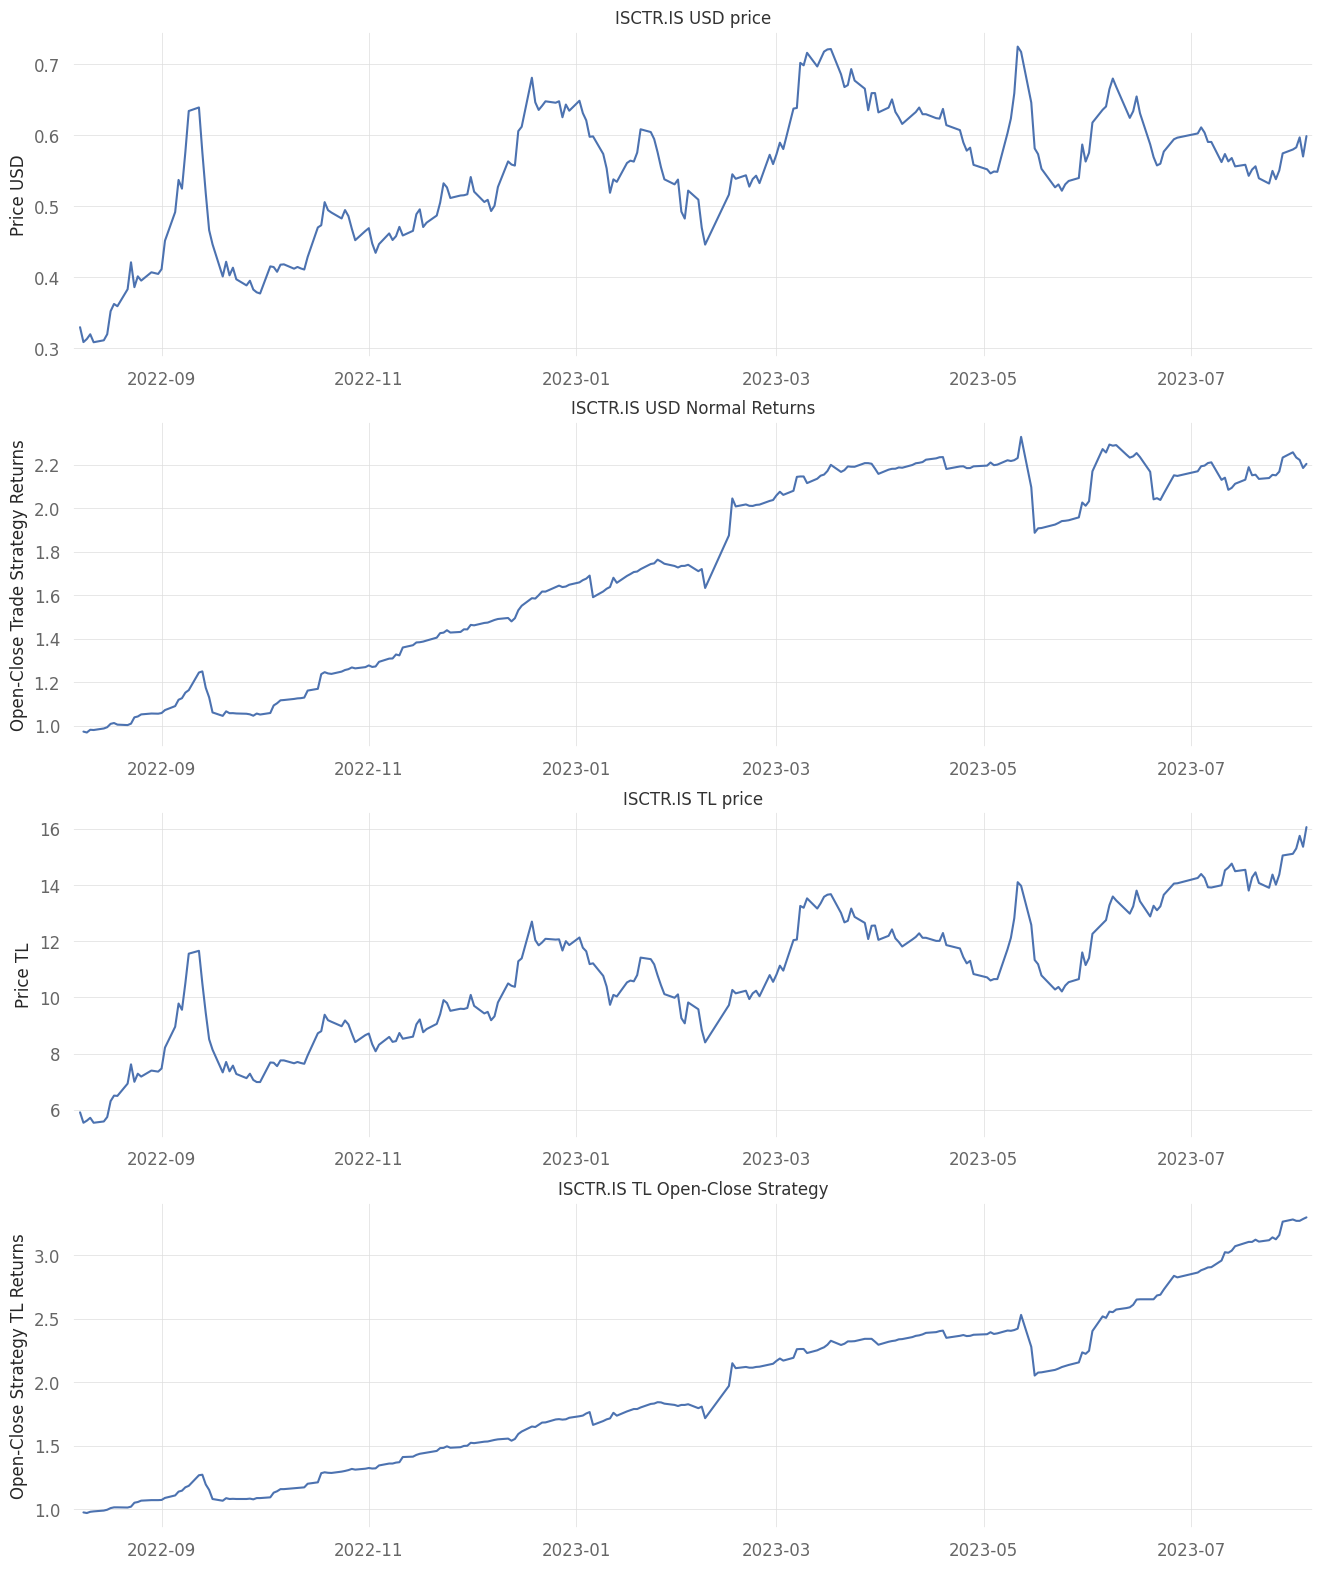

Creating Tear Sheet for ISCTR.IS


Updating data for PETKM.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for PETKM.IS
Plotting Open-Close Performance for PETKM.IS


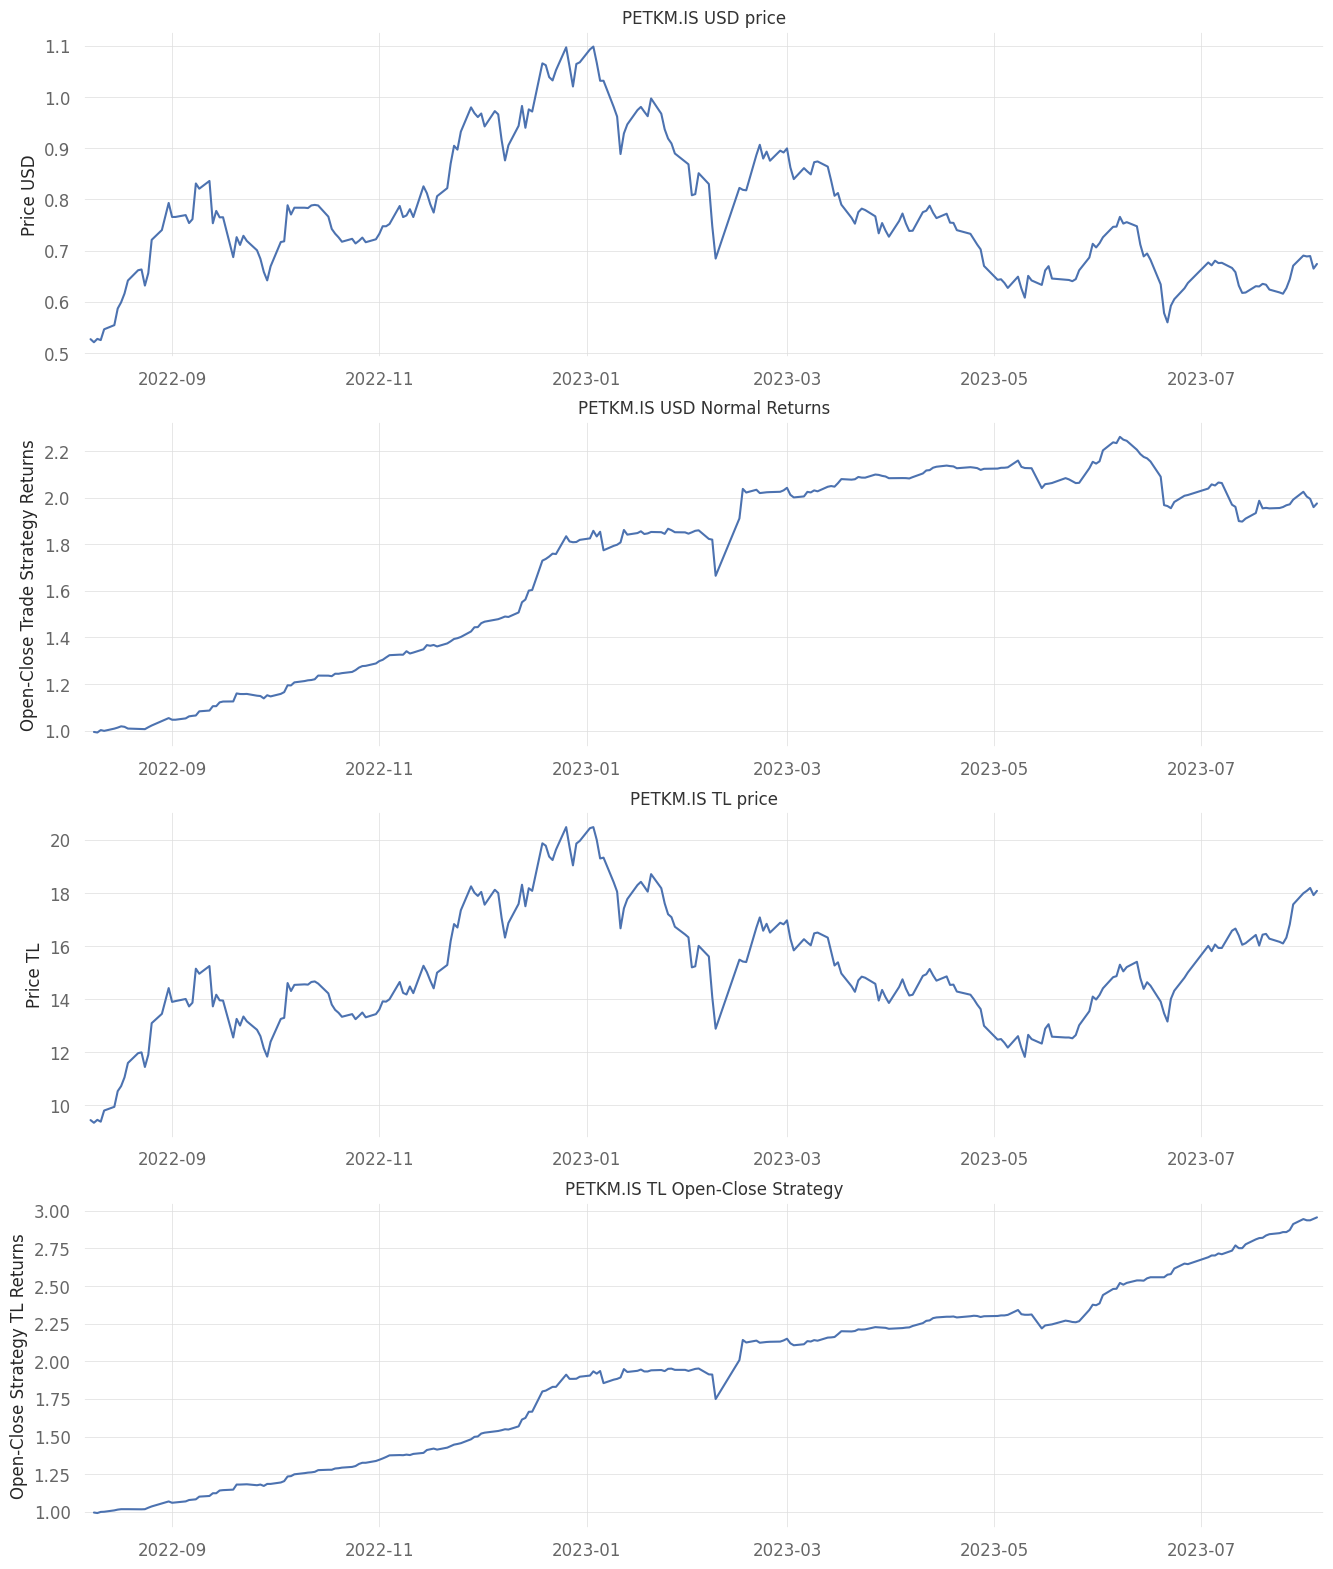

Creating Tear Sheet for PETKM.IS


Updating data for TAVHL.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for TAVHL.IS
Plotting Open-Close Performance for TAVHL.IS


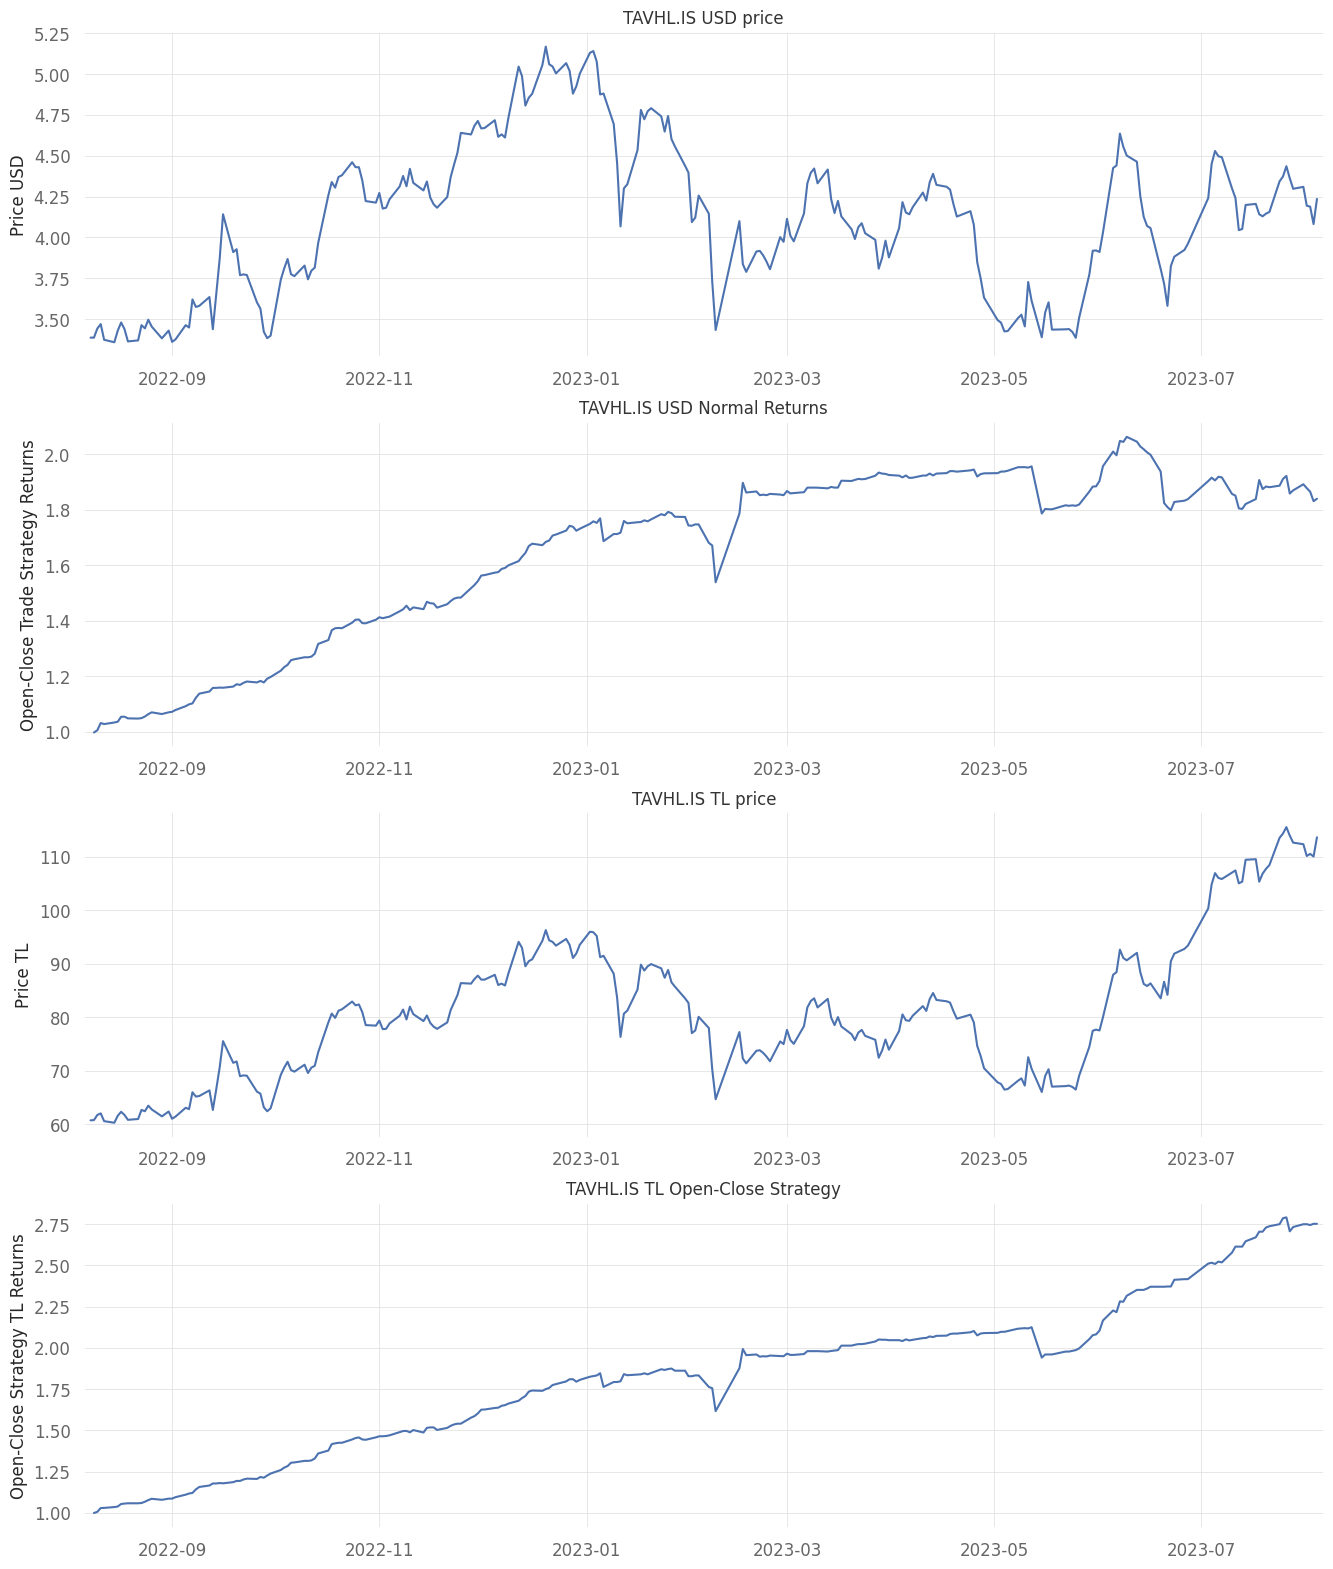

Creating Tear Sheet for TAVHL.IS


Updating data for EREGL.IS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for EREGL.IS
Plotting Open-Close Performance for EREGL.IS


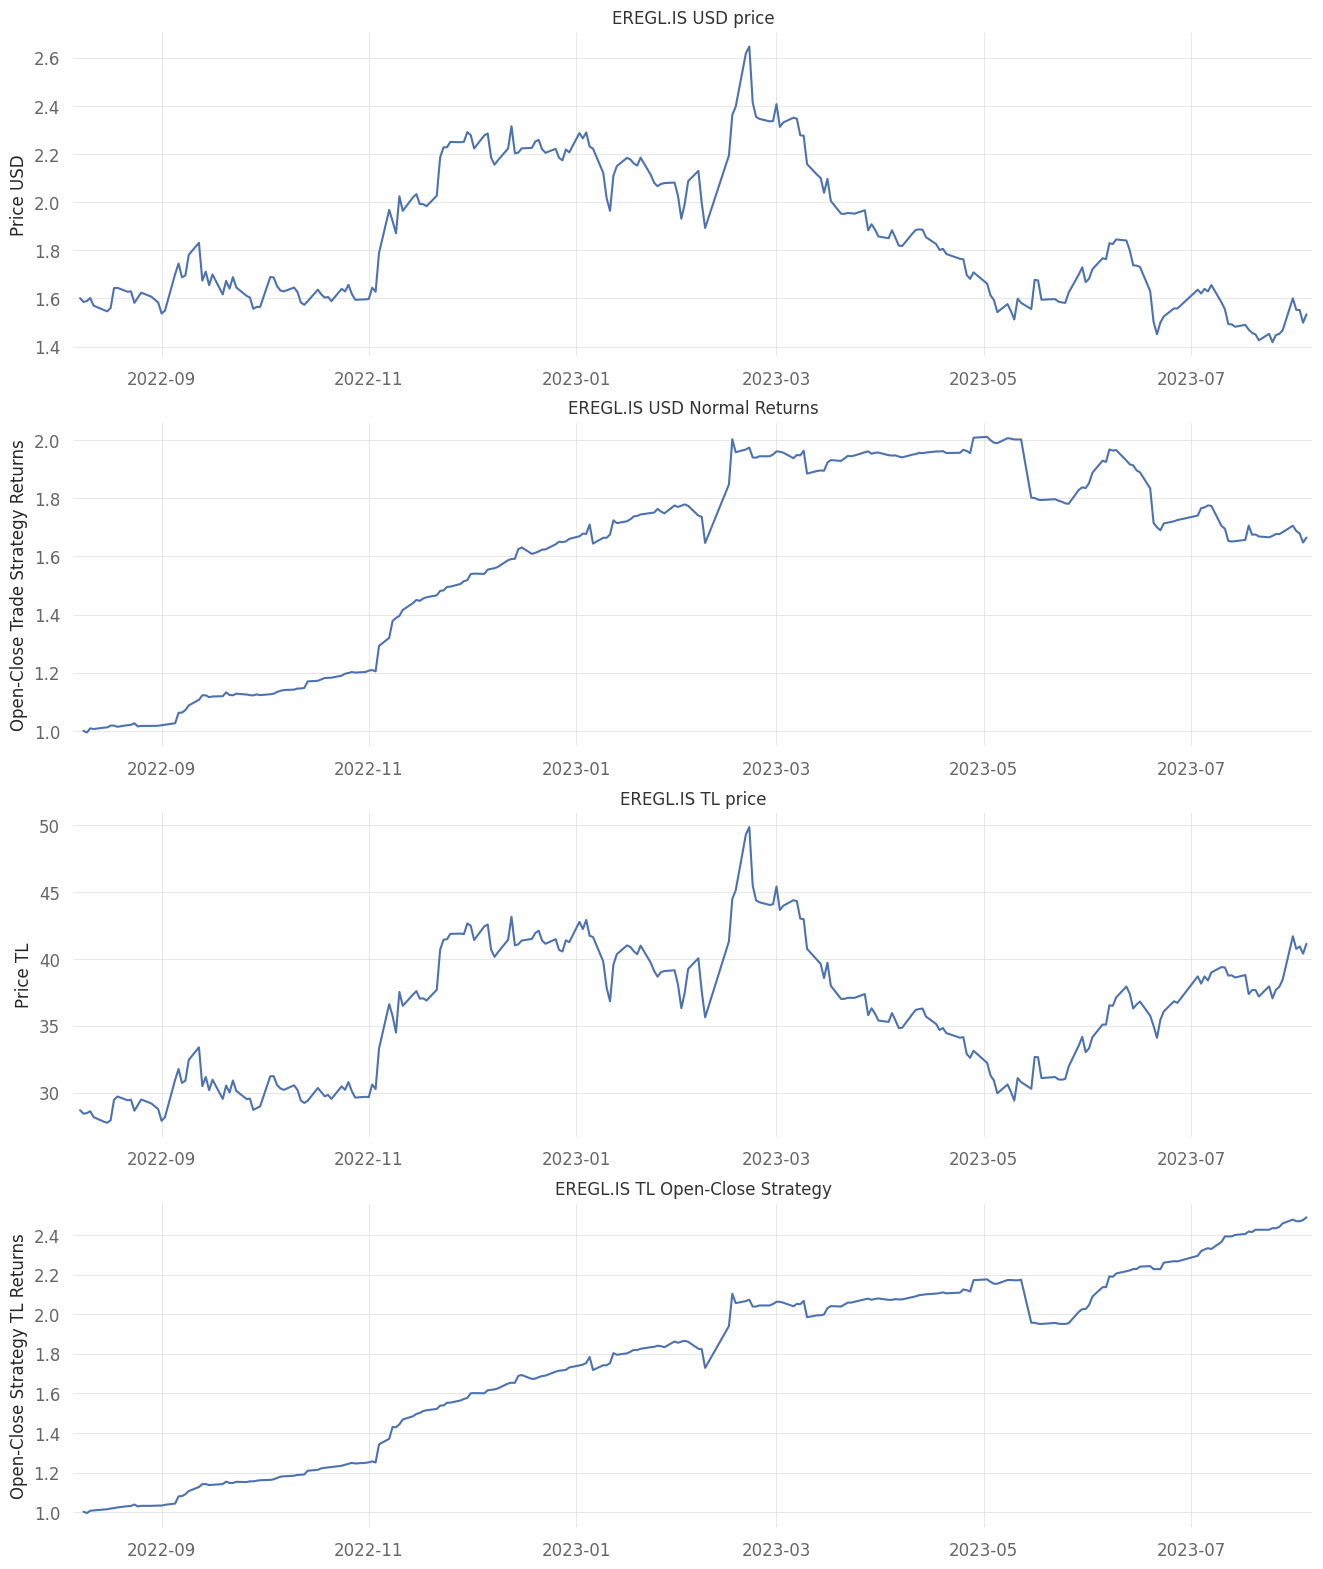

Creating Tear Sheet for EREGL.IS


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

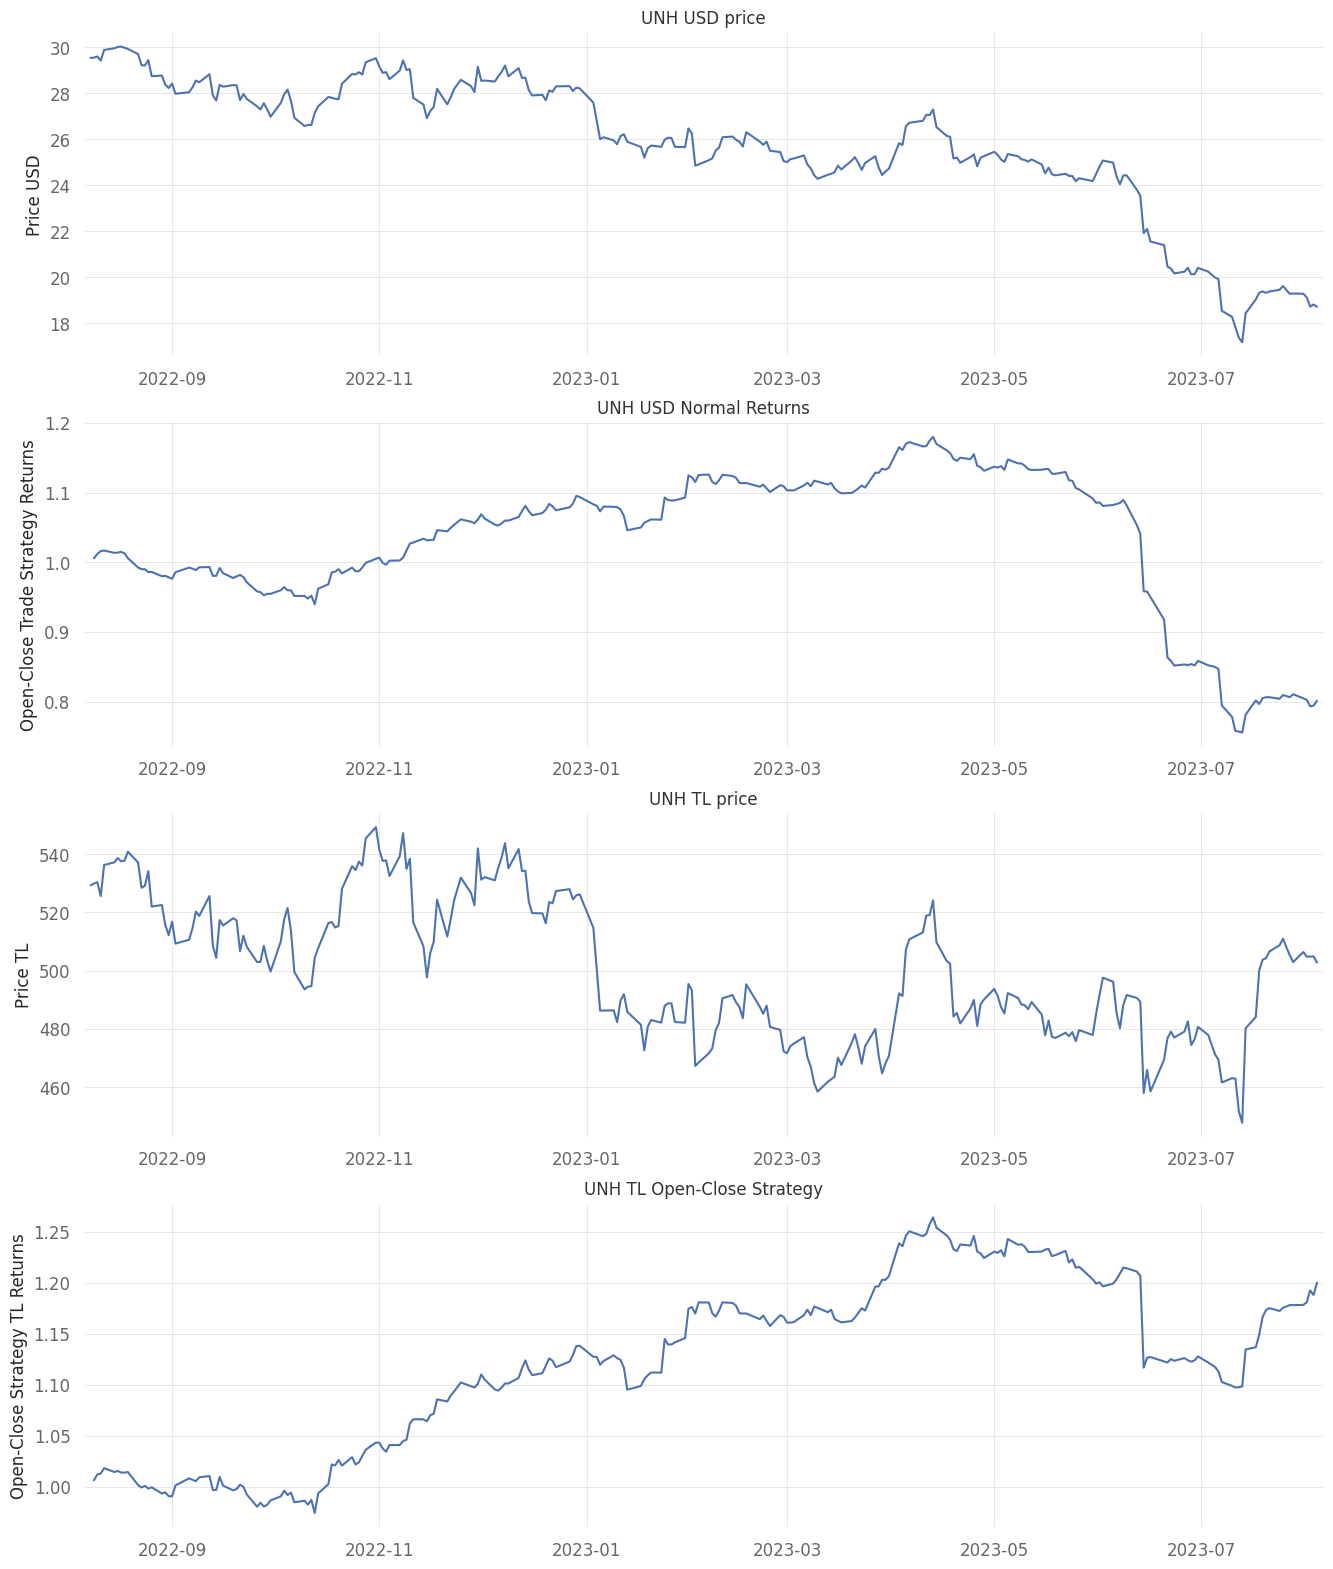

Creating Tear Sheet for UNH


Updating data for WBA
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for WBA
Plotting Open-Close Performance for WBA


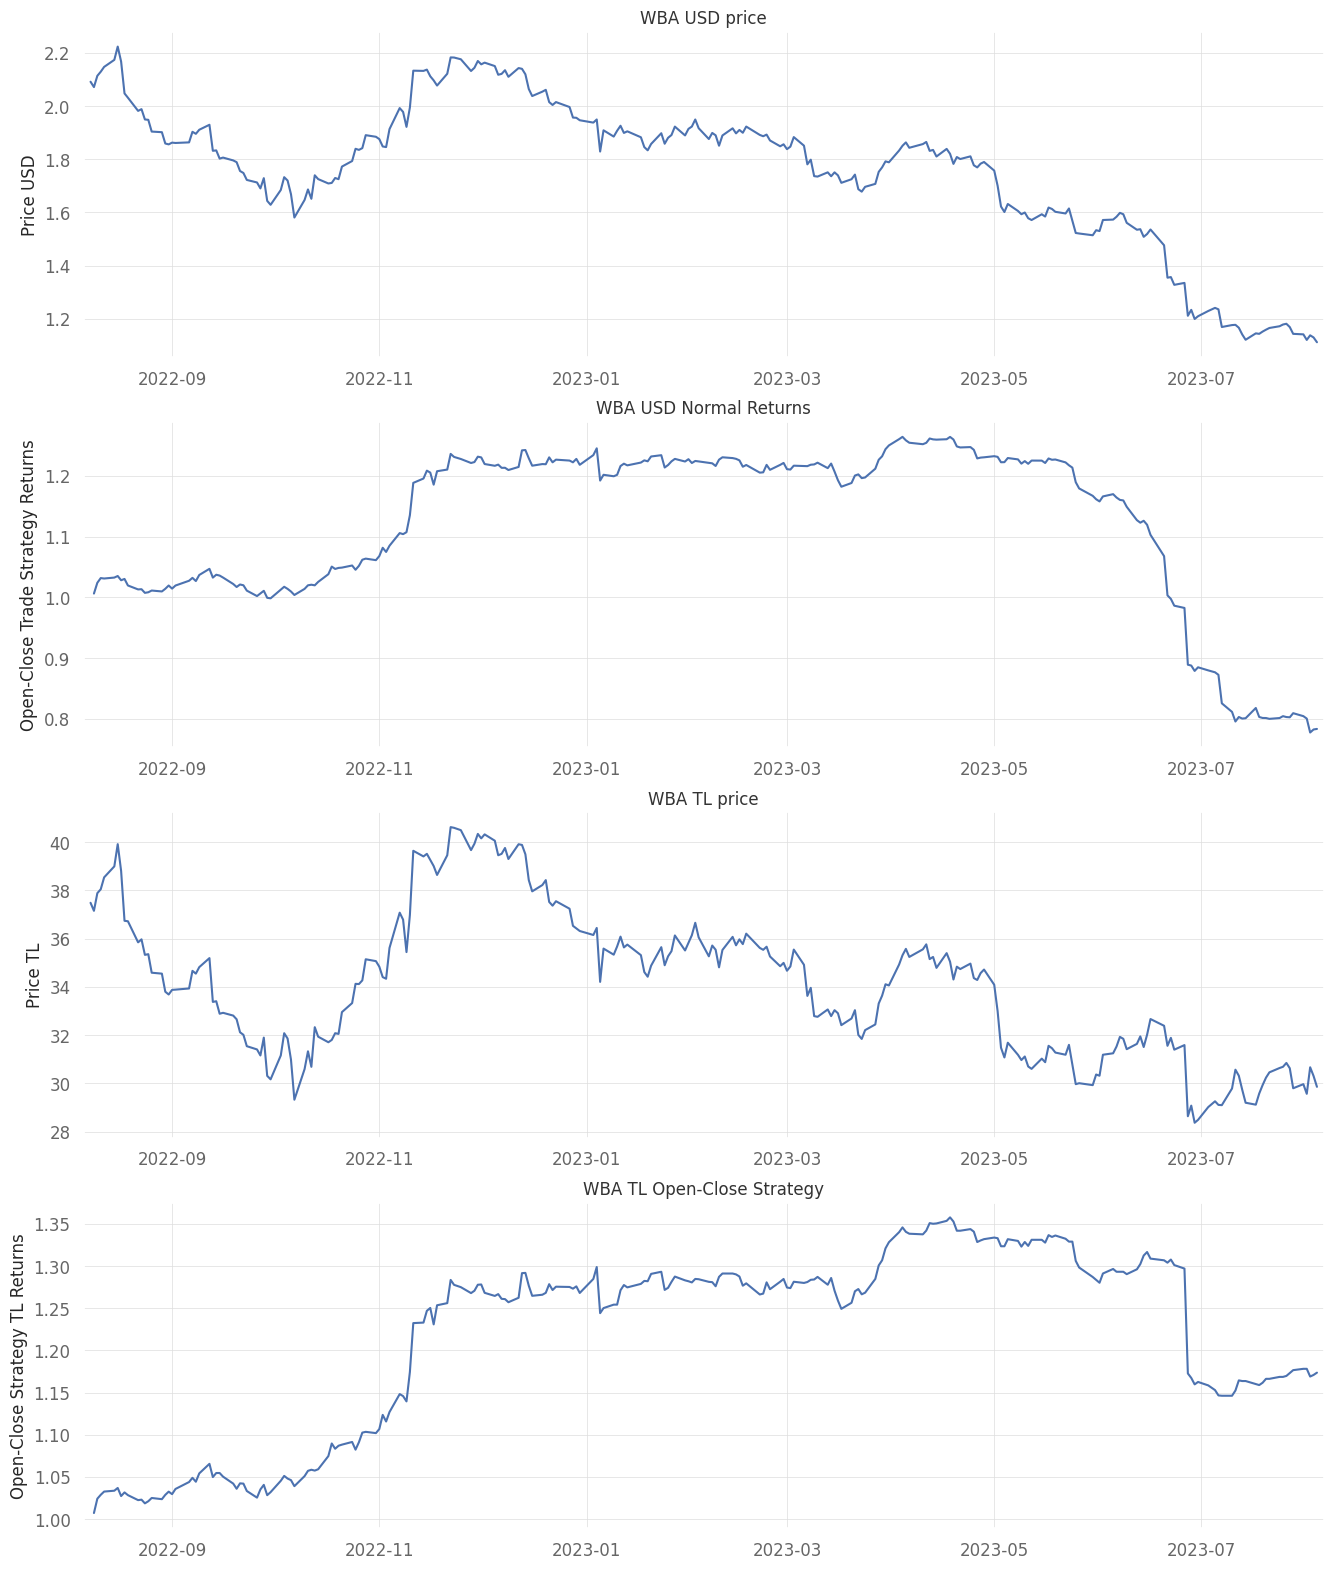

Creating Tear Sheet for WBA


Updating data for MMM
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for MMM
Plotting Open-Close Performance for MMM


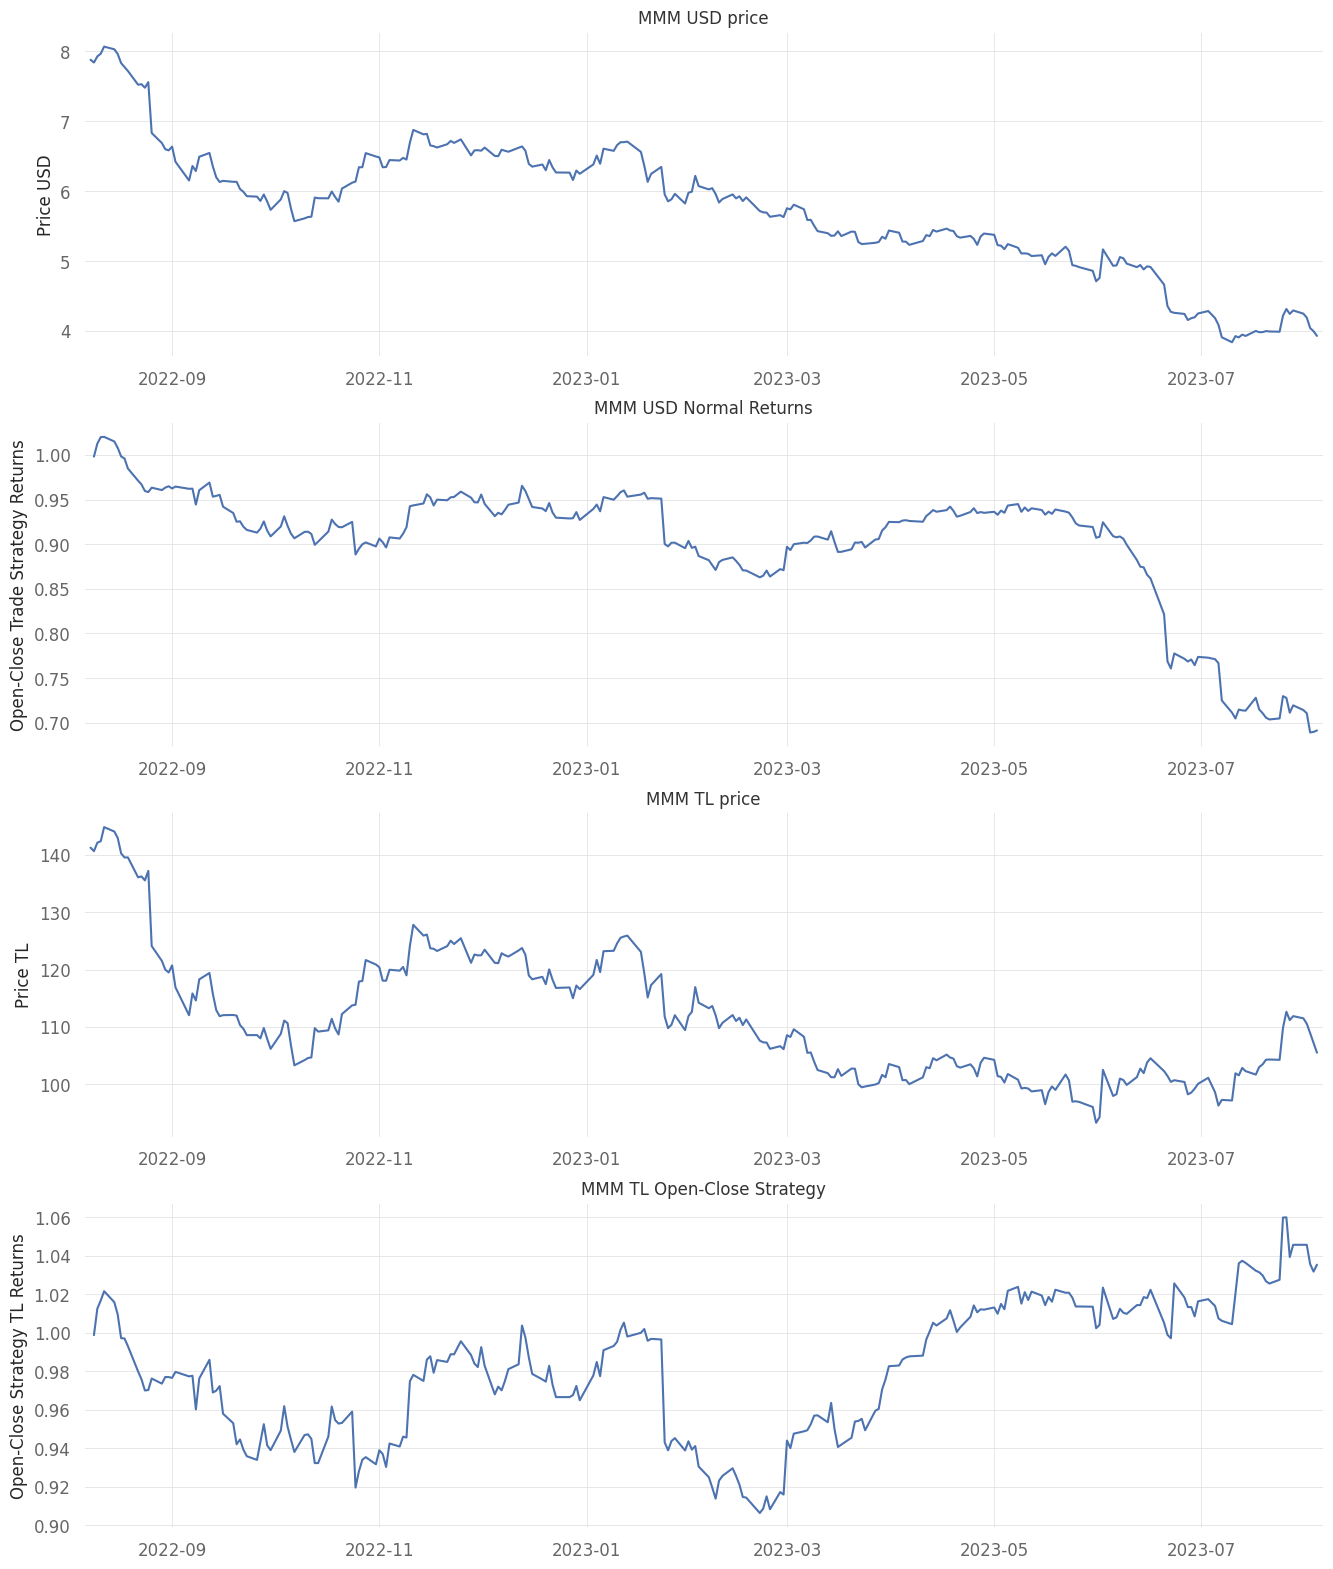

Creating Tear Sheet for MMM


Updating data for DIS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for DIS
Plotting Open-Close Performance for DIS


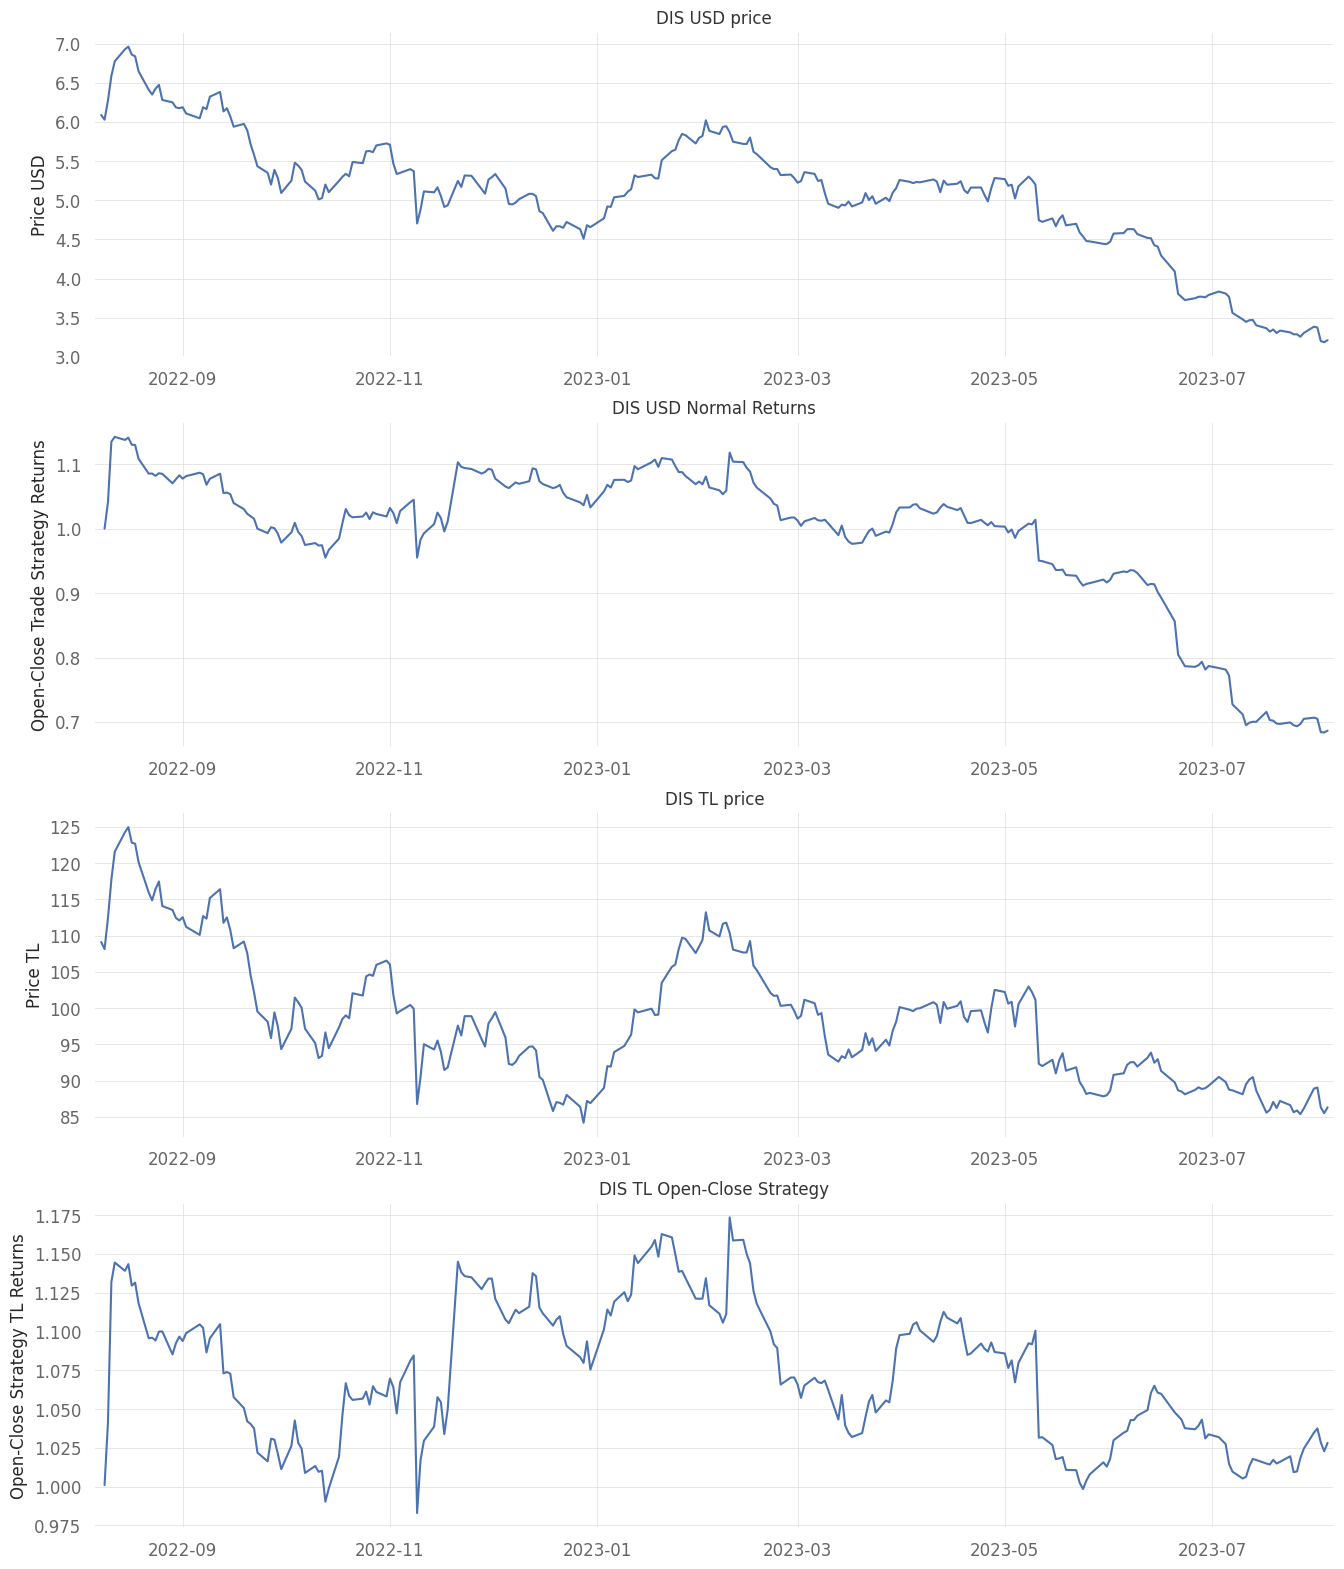

Creating Tear Sheet for DIS


Updating data for VZ
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Applying Strategy data for VZ
Plotting Open-Close Performance for VZ


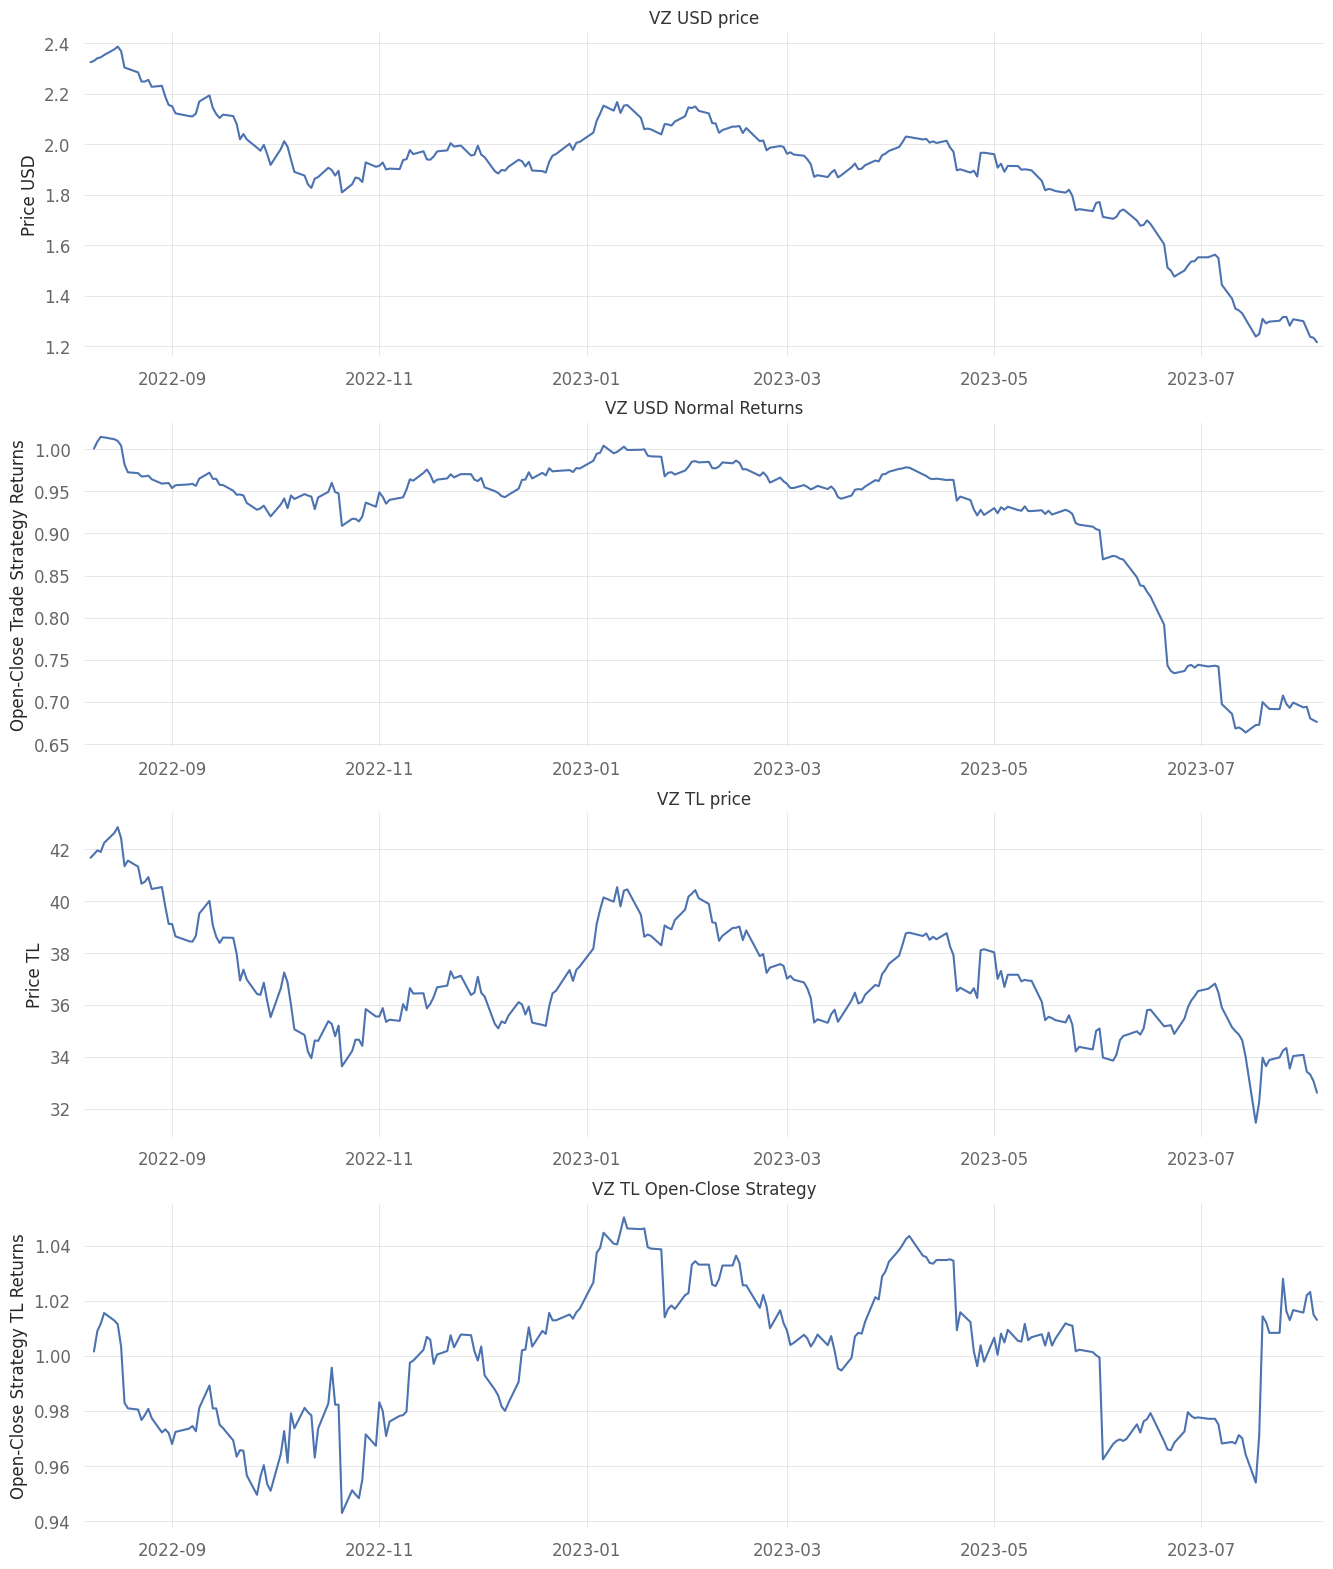

Creating Tear Sheet for VZ


Start date: 2022-8-6
End date: 2023-08-06


Backtest
                            
Annual return        139.24%
Cumulative return    135.95%
Annual volatility     46.1 %
Winning day ratio     57.26%
Sharpe ratio            2.12
Calmar ratio            2.33
Information ratio        0.0
Stability               0.51
Max Drawdown         -35.4 %
Sortino ratio           3.52
Skew                    0.98
Kurtosis                8.62
Tail Ratio              1.11
Common sense ratio       1.6
Daily value at risk   -4.0 %
Alpha                    1.4
Beta                    0.24

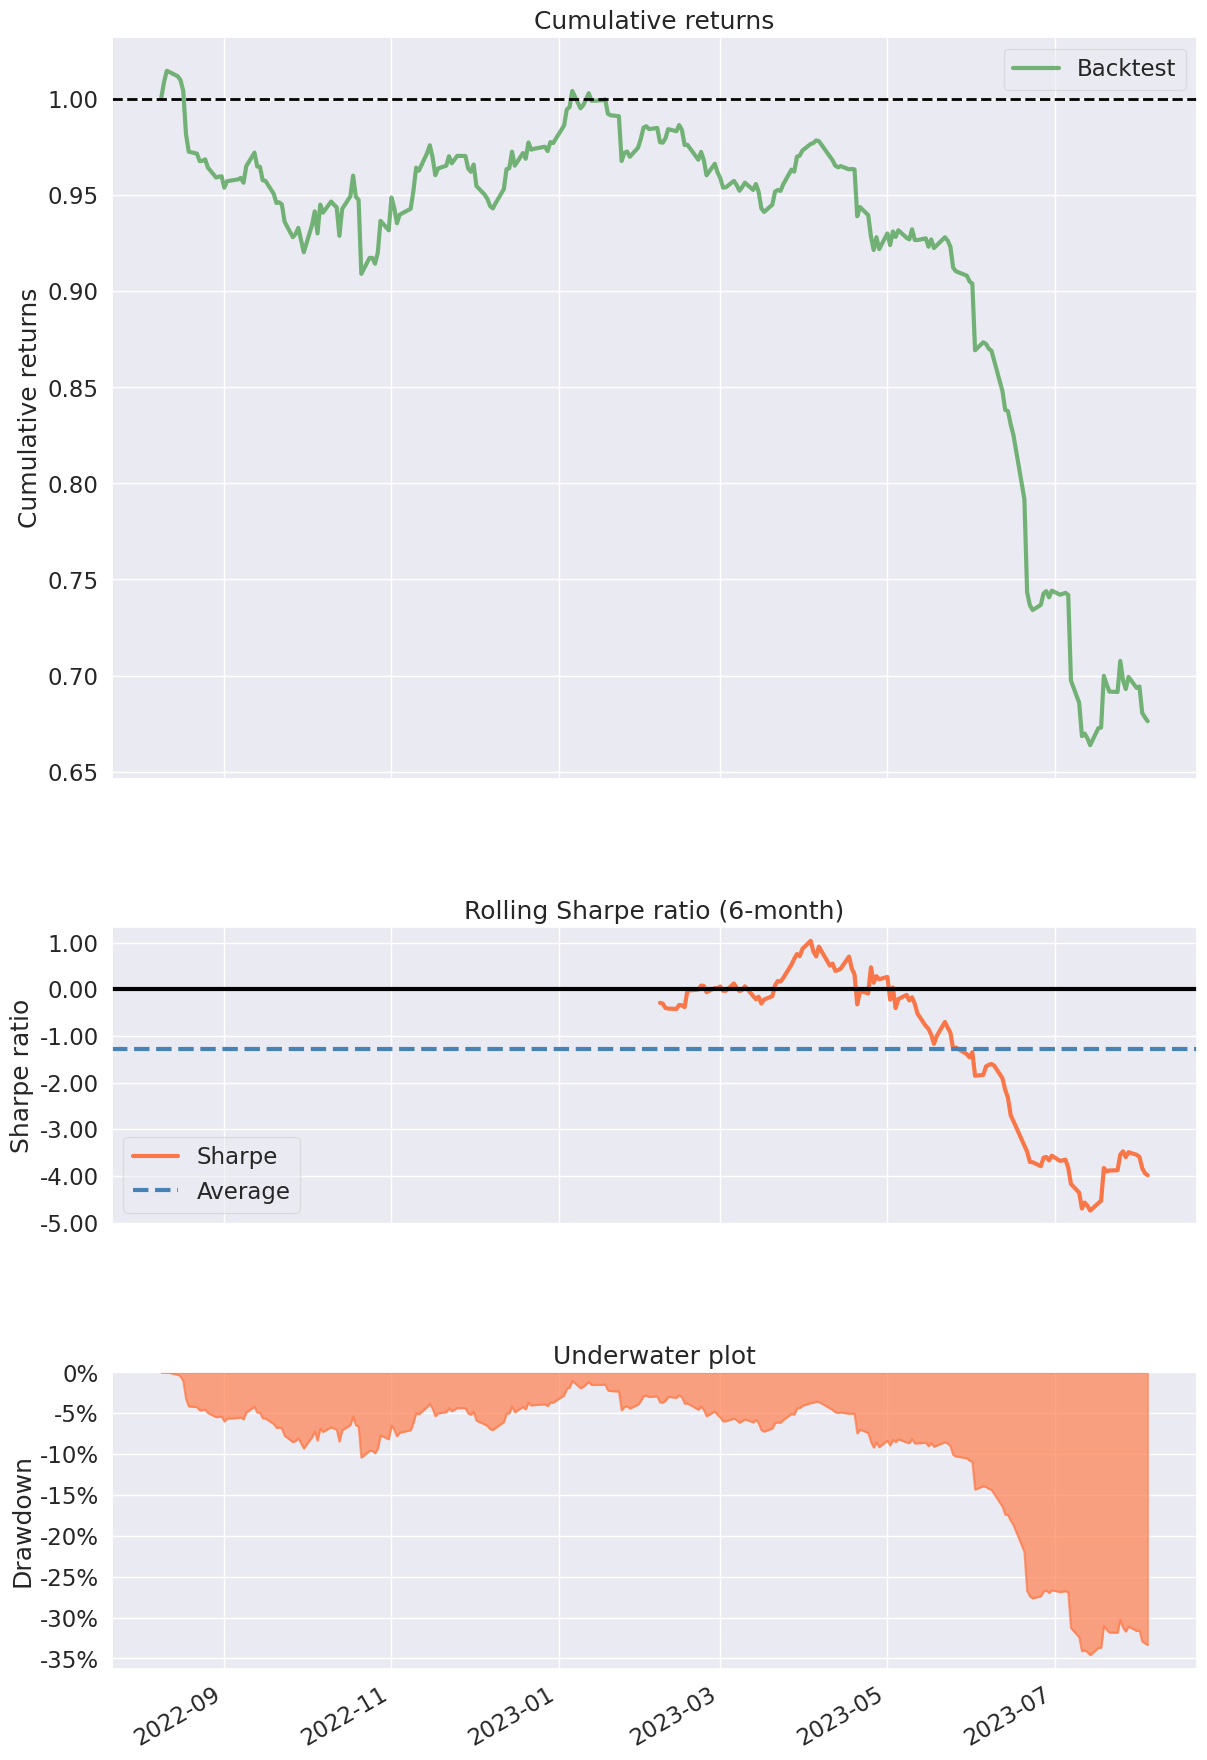

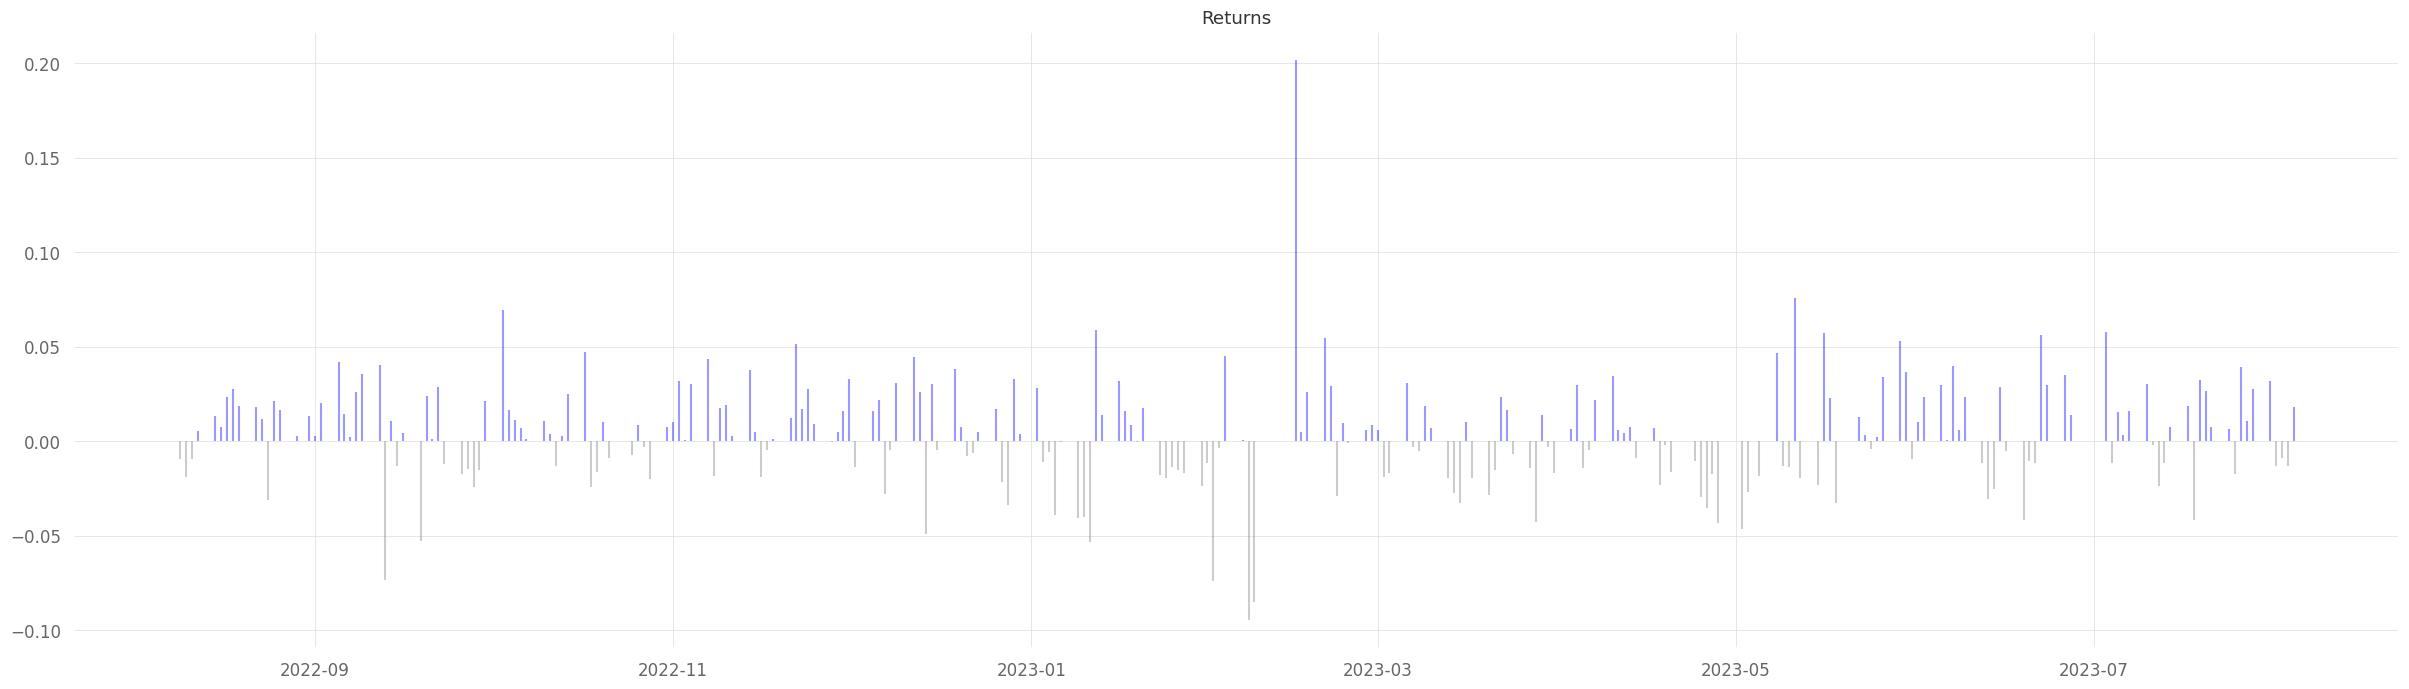

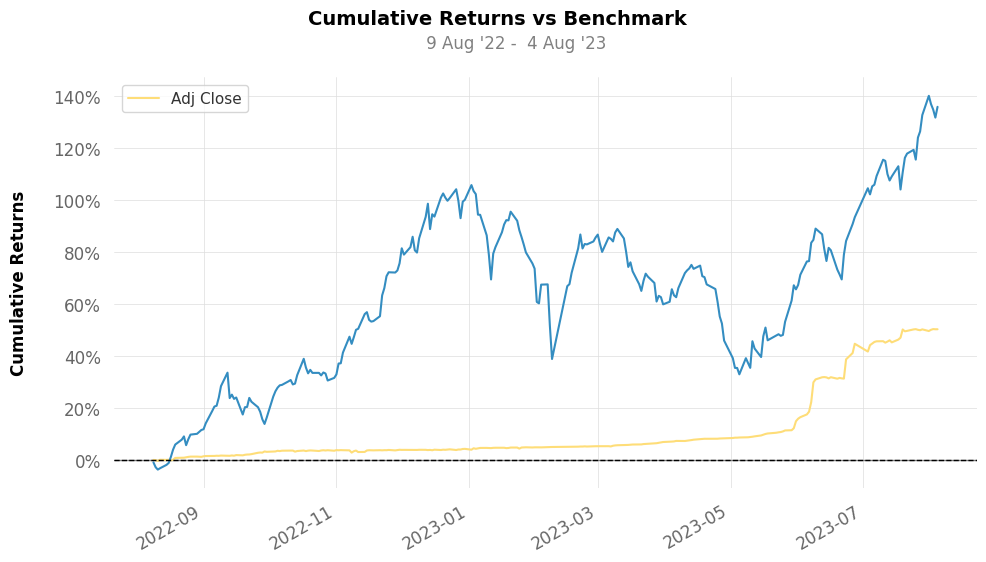

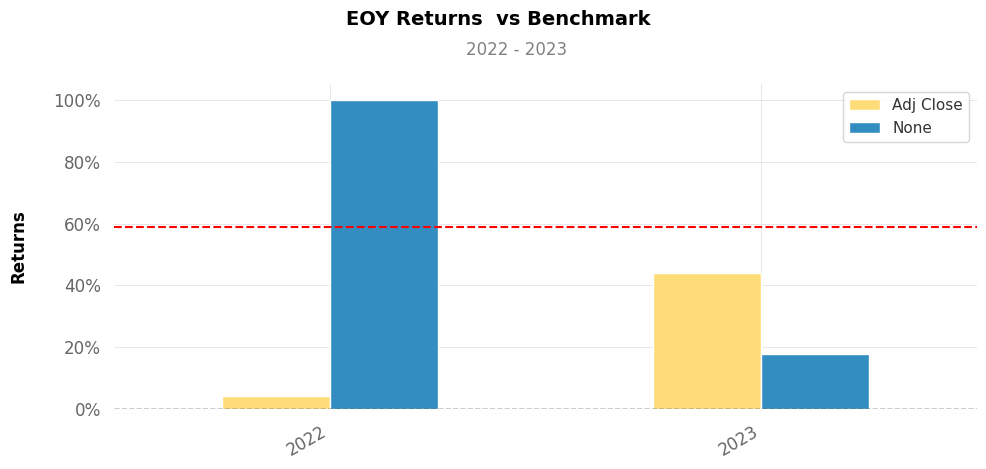

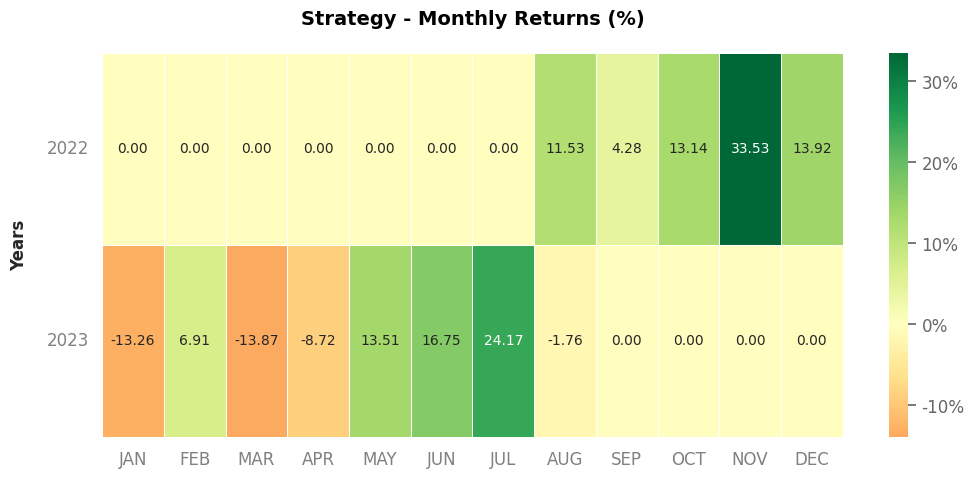

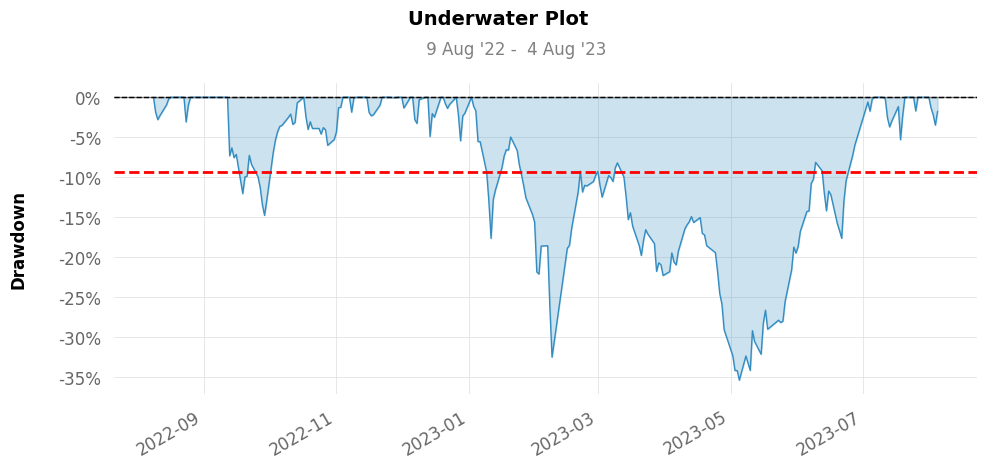

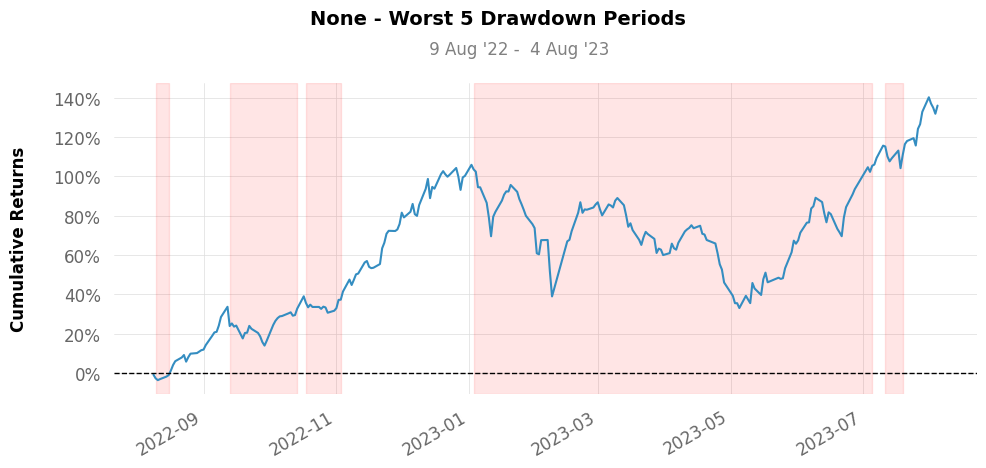

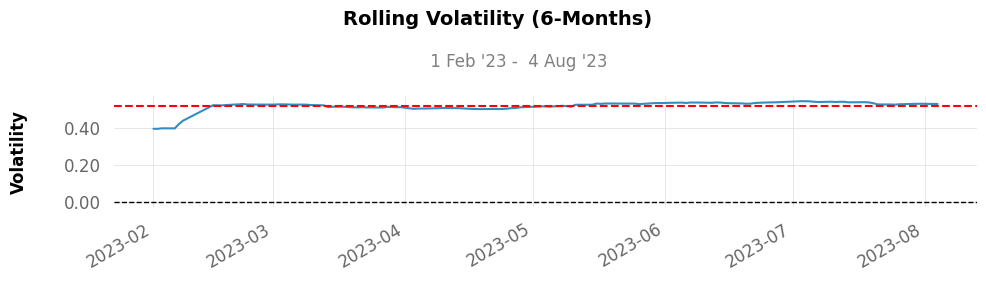

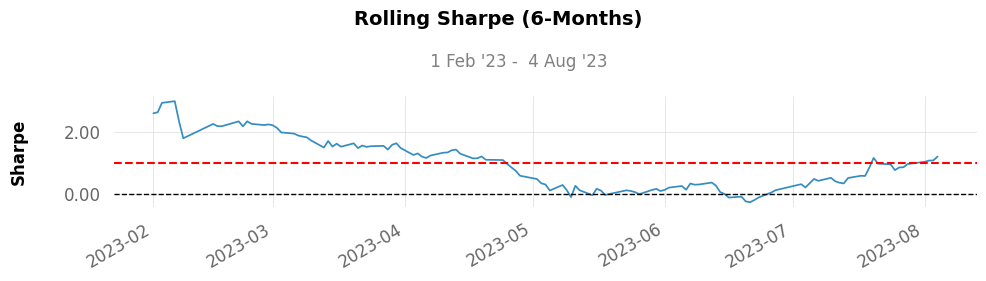

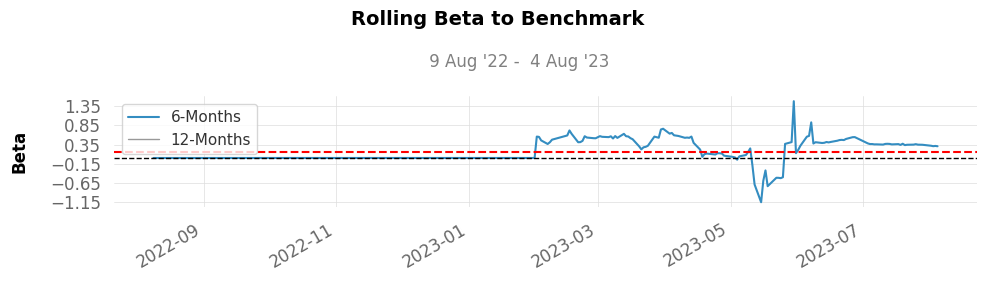

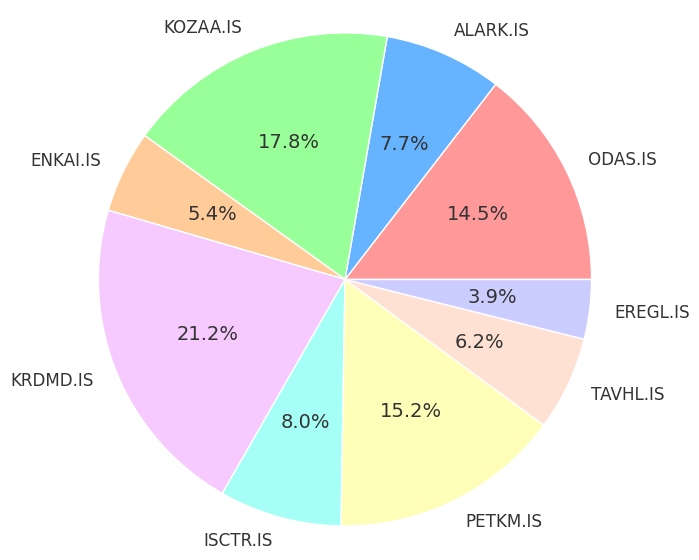

In [173]:
def main():

  bist_df = ShowTRMarket_v2(BIST30)
  for ticker in bist_df['Ticker']:
    ShowTickerStats( ticker,"BIST")

  dow_df = ShowUSMarket_v2(DOW30)
  for ticker in dow_df['Ticker']:
      ShowTickerStats( ticker,"US")

  EmpyrialPortfolioPerformance()

if __name__ == "__main__":
    main()